In [4]:
!unzip /content/cnndata.zip -d /content/


Archive:  /content/cnndata.zip
   creating: /content/cnndata/
   creating: /content/cnndata/images/
  inflating: /content/cnndata/images/06_2866_079.png  
  inflating: /content/cnndata/images/0_$0.99-_0_19.png  
  inflating: /content/cnndata/images/0_$1.40_0_16.png  
  inflating: /content/cnndata/images/0_$10.00_0_1.png  
  inflating: /content/cnndata/images/0_$10.00_0_2.png  
  inflating: /content/cnndata/images/0_$11.00_0_0.png  
  inflating: /content/cnndata/images/0_$11.00_0_0_0.png  
  inflating: /content/cnndata/images/0_$11.00_0_17 (2).png  
  inflating: /content/cnndata/images/0_$11.00_0_17 (3).png  
  inflating: /content/cnndata/images/0_$11.00_0_17.png  
  inflating: /content/cnndata/images/0_$12.00_0_10.png  
  inflating: /content/cnndata/images/0_$12.00_0_3.png  
  inflating: /content/cnndata/images/0_$12.00_0_8.png  
  inflating: /content/cnndata/images/0_$12.00_0_8_2.png  
  inflating: /content/cnndata/images/0_$12.71_0_5.png  
  inflating: /content/cnndata/images/0_$12.7

In [5]:
# Install OpenCV
!pip install opencv-python

# NumPy and TensorFlow are usually pre-installed, but you can upgrade if needed
!pip install numpy tensorflow


In [11]:


import os,json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split



# -------------------
# Config
# -------------------
img_height = 31
num_channels = 1
vocab = "0123456789.,-+{}()$￥@;~ " # Added space to vocab

num_classes = len(vocab) + 2  # last index for CTC blank
max_label_len = 14           # 13max length of text in dataset
batch_size = 16

# -------------------
# Vocabulary mapping
# -------------------
char_to_idx = {c:i+1 for i,c in enumerate(vocab)}  # 0 reserved for blank
idx_to_char = {i+1:c for i,c in enumerate(vocab)}

def text_to_labels(text):
    return [char_to_idx[c] for c in text]

# -------------------
# Load data
# -------------------
data_path = "/content/cnndata/images"
label_file = "/content/cnndata/labels.json"

# Load JSON
with open(label_file, "r", encoding="utf-8") as f:
    labels = json.load(f)

image_paths = []
label_sequences = []
texts = []
for item in labels:
    fname = item["filename"]
    text = item["annotation"]
    texts.append(text)

    image_paths.append(os.path.join(data_path, fname))
    label_sequences.append(list(text_to_labels(text)))

print('label_sequences',label_sequences)
print('texts',texts)

# Split into train/eval
train_img, val_img, train_labels, val_labels, train_texts, val_texts = train_test_split(
    image_paths, label_sequences, texts,
    test_size=0.2,  # 20% for validation
    random_state=42,
    shuffle=True
)

print("Training samples:", len(train_img))
print("Validation samples:", len(val_img))


# -------------------
# Data generator
# -------------------
def data_generator(image_paths, label_sequences, batch_size, img_height, downsample_factor=4, max_label_len=max_label_len):
    # Sort the images by their widths
    sorted_indices = np.argsort([
        int(cv2.imread(path, cv2.IMREAD_GRAYSCALE).shape[1] * (img_height / cv2.imread(path, cv2.IMREAD_GRAYSCALE).shape[0]))
        for path in image_paths
    ])
    sorted_image_paths = [image_paths[i] for i in sorted_indices]
    sorted_label_sequences = [label_sequences[i] for i in sorted_indices]

    index = 0
    while True:
        bucket = []
        while len(bucket) < batch_size and index < len(sorted_image_paths):
            img_path = sorted_image_paths[index]
            label = sorted_label_sequences[index]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARN] Could not read image: {img_path}")
                index += 1
                continue

            ratio = img_height / img.shape[0]
            new_w = int(img.shape[1] * ratio)
            bucket.append((new_w, img_path, label))
            index += 1

            if len(bucket) == batch_size or index == len(sorted_image_paths):
                break

        if not bucket:
            index = 0
            continue

        # Process images
        processed, labels, label_lengths = [], [], []
        for new_w, img_path, label in bucket:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            resized = cv2.resize(img, (new_w, img_height))
            resized = resized.astype(np.float32) / 255.0
            resized = np.expand_dims(resized, axis=-1)
            processed.append(resized)
            labels.append(label)
            label_lengths.append(len(label))

        max_w = max(img.shape[1] for img in processed)
        padded_imgs = np.ones((len(processed), img_height, max_w, 1), dtype=np.float32)
        for j, img in enumerate(processed):
            padded_imgs[j, :, :img.shape[1], :] = img

        Y_padded = np.zeros((len(labels), max_label_len), dtype=np.int32)
        for j, label in enumerate(labels):
            trunc = label[:max_label_len]
            Y_padded[j, :len(trunc)] = trunc

        input_lengths = np.array([[img.shape[1] // downsample_factor] for img in processed])
        label_lengths = np.array(label_lengths).reshape(-1, 1)

        yield {
            "input": padded_imgs,
            "label": Y_padded,
            "input_length": input_lengths,
            "label_length": label_lengths
        }, np.zeros(len(processed))



# -------------------
# Build CRNN
# -------------------
inputs = layers.Input(shape=(img_height,None,num_channels), name="input")

x = layers.Conv2D(64, 5, padding="same", activation="relu")(inputs)
# x = layers.Conv2D(64, 5, padding="same", activation="relu")(x) #new
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, 5, padding="same", activation="relu")(x)
# x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)  # Added
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
# x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)  # Added
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,1))(x)

x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, 3, padding="same", activation="relu")(x)  # Added
x = layers.MaxPooling2D((2,1))(x)

# Dropout before RNN
x = layers.Dropout(0.25)(x)

# Reshape for RNN
new_shape = (-1, x.shape[1]*x.shape[3])
x = layers.Reshape(target_shape=new_shape)(x)

# RNN layers
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)


outputs = layers.Dense(num_classes, activation="softmax")(x)

base_model = models.Model(inputs, outputs, name="CRNN")

# -------------------
# CTC Loss
# -------------------
labels = layers.Input(name="label", shape=(max_label_len,), dtype="int32")
input_length = layers.Input(name="input_length", shape=(1,), dtype="int32")
label_length = layers.Input(name="label_length", shape=(1,), dtype="int32")

def ctc_lambda(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = layers.Lambda(ctc_lambda, output_shape=(1,), name="ctc")(
    [outputs, labels, input_length, label_length]
)

training_model = models.Model(
    inputs=[inputs, labels, input_length, label_length],
    outputs=loss_out
)

# Set your learning rate
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

training_model.compile(optimizer="adam", loss={"ctc": lambda y_true, y_pred: y_pred})

# -------------------
# Training
# -------------------
# Define early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

steps_per_epoch = len(train_img) // batch_size
validation_steps = len(val_img) // batch_size

training_model.fit(
    data_generator(train_img, train_labels, batch_size, img_height),
    steps_per_epoch=steps_per_epoch,
    validation_data=data_generator(val_img, val_labels, batch_size, img_height),
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[early_stop]
)


label_sequences [[3, 9, 7, 7], [19, 1, 11, 10, 10, 13], [19, 2, 11, 5, 1], [19, 2, 1, 11, 1, 1], [19, 2, 1, 11, 1, 1], [19, 2, 2, 11, 1, 1], [19, 2, 2, 11, 1, 1], [19, 2, 2, 11, 1, 1], [19, 2, 2, 11, 1, 1], [19, 2, 2, 11, 1, 1], [19, 2, 3, 11, 1, 1], [19, 2, 3, 11, 1, 1], [19, 2, 3, 11, 1, 1], [19, 2, 3, 11, 1, 1], [19, 2, 3, 11, 8, 2], [19, 2, 3, 11, 8, 2], [19, 2, 5, 4, 11, 8, 2], [19, 2, 5, 4, 11, 8, 2], [19, 2, 8, 11, 1, 1], [19, 2, 8, 11, 1, 1], [19, 3, 11, 2, 5], [19, 3, 11, 3, 10], [19, 4, 7, 11, 1, 1], [19, 4, 9, 11, 9, 7], [19, 5, 11, 10, 8], [19, 6, 2, 11, 9, 3], [19, 6, 5, 11, 1, 1], [19, 7, 11, 1, 1], [19, 7, 11, 2, 3], [19, 8, 5, 11, 1, 1], [19, 9, 11, 1, 1], [19, 9, 5, 11, 1, 1], [17, 7, 6, 4, 6, 2, 13, 18], [14, 19, 1, 11, 1, 1], [14, 19, 1, 11, 1, 1], [14, 19, 5, 11, 1, 1], [13, 1, 11, 1, 2], [11, 1, 1, 2, 6, 5], [1, 11, 1, 1], [1, 11, 3, 1], [1, 11, 5, 3], [1, 11, 5, 9], [1, 11, 6, 1], [1, 11, 6, 8], [1, 11, 9, 4], [1, 1, 1, 2, 5, 2], [1, 2, 1, 1, 1, 1], [1, 3, 1, 2, 1

In [7]:
import json

label_file = "/content/cnndata/labels.json"

with open(label_file, "r", encoding="utf-8") as f:
    labels_data = json.load(f)

max_annotation_length = 0
for item in labels_data:
    annotation_length = len(item["annotation"])
    if annotation_length > max_annotation_length:
        max_annotation_length = annotation_length

print(f"Maximum annotation length found: {max_annotation_length}")

Maximum annotation length found: 13


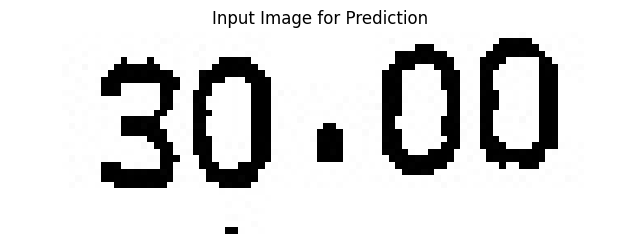

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Decoded: ['1', '0']
Decoded: []


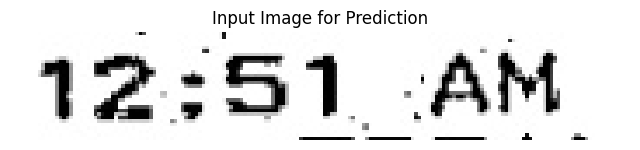

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Decoded: ['1', '.']
Decoded: ['.']


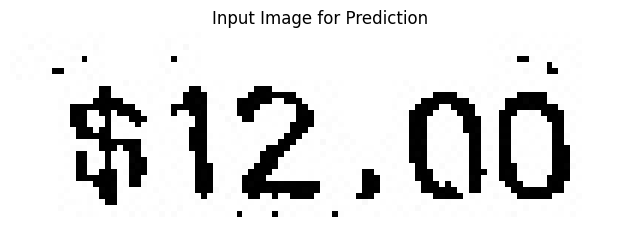

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Decoded: ['1', '0']
Decoded: ['1']


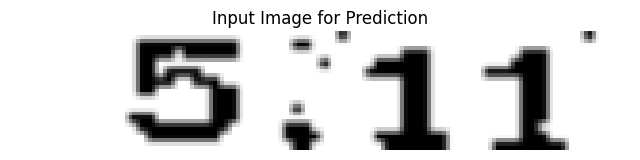

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Decoded: ['1', '.']
Decoded: []


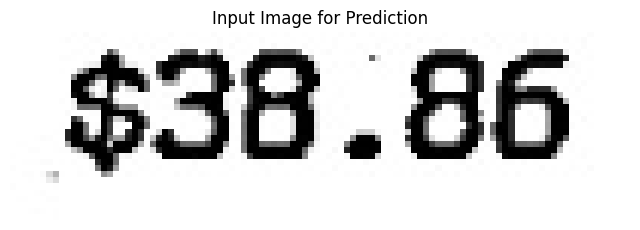

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Decoded: ['1', '0']
Decoded: []


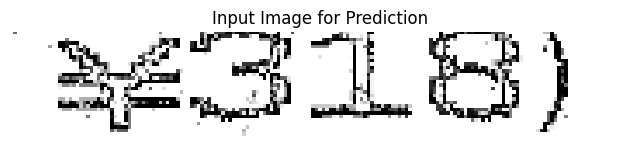

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Decoded: ['1', '0']
Decoded: []


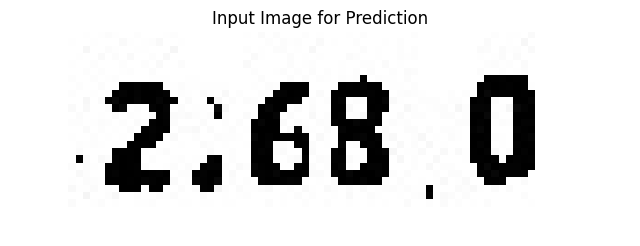

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Decoded: ['1', '.']
Decoded: ['.']


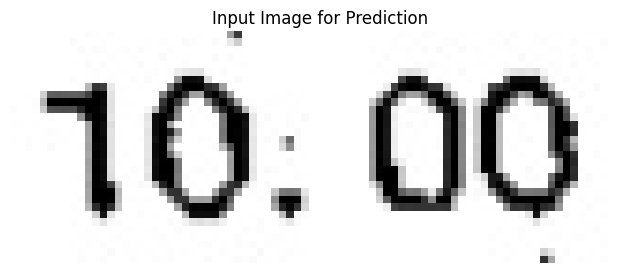

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
Decoded: ['1', '.']
Decoded: ['.']


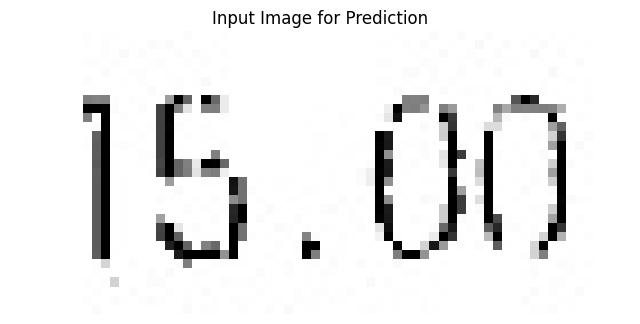

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Decoded: ['1', '.']
Decoded: ['1']


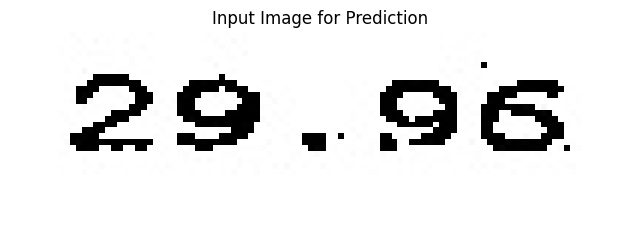

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Decoded: ['1', '0']
Decoded: []


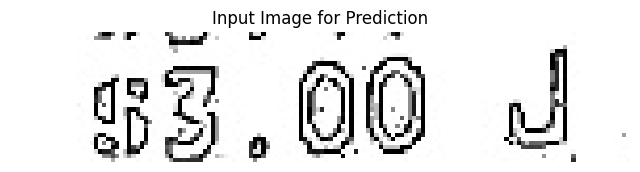

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Decoded: ['1', '.']
Decoded: []


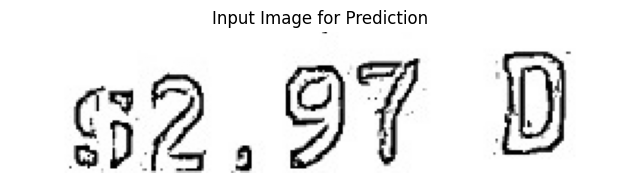

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Decoded: ['1', '.']
Decoded: ['.']


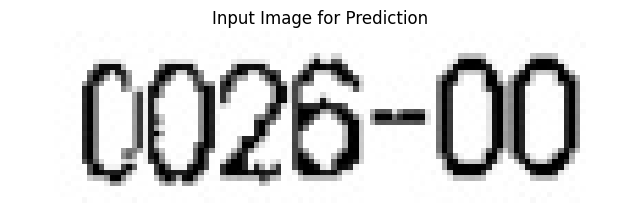

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Decoded: ['1', '.']
Decoded: []


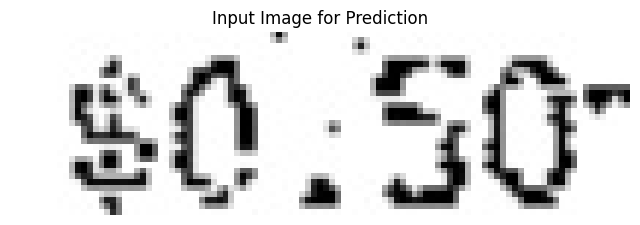

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Decoded: ['1', '.']
Decoded: ['.']


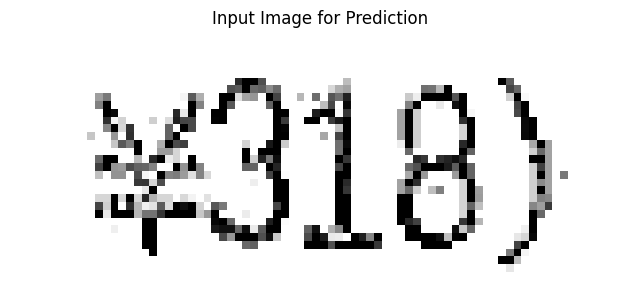

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Decoded: ['1', '0']
Decoded: ['1']


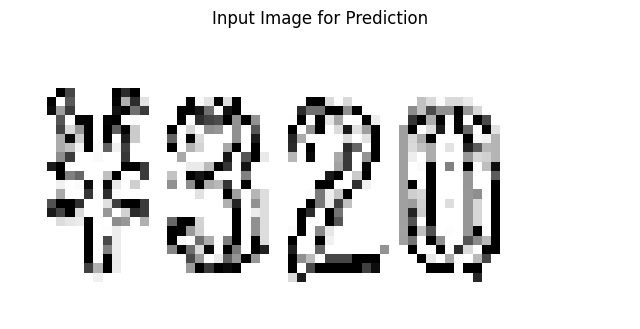

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Decoded: ['1', '0']
Decoded: ['1']


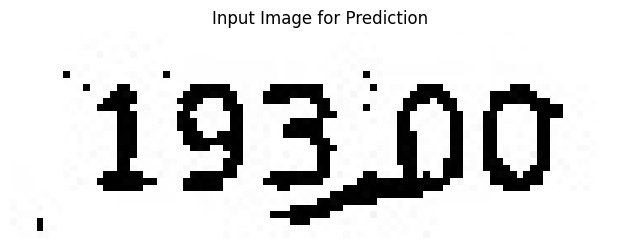

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Decoded: ['1', '0']
Decoded: []


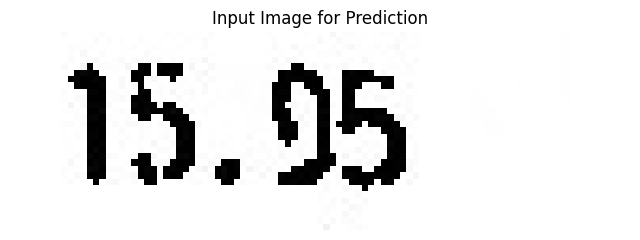

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Decoded: ['1', '0']
Decoded: ['1']


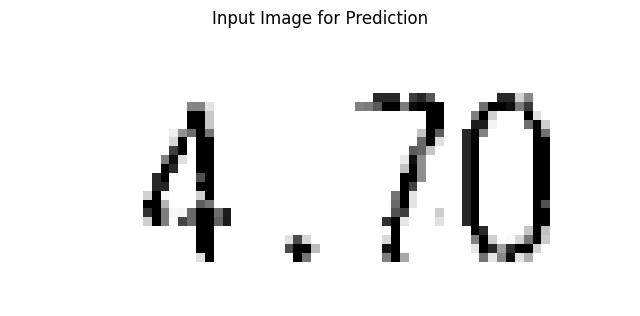

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Decoded: ['1', '.']
Decoded: []


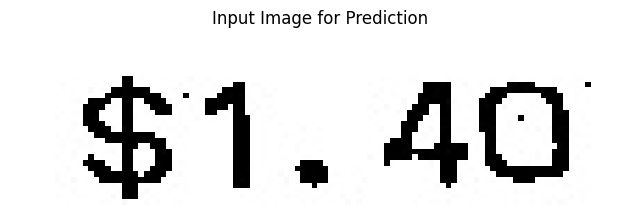

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Decoded: ['1', '.']
Decoded: []


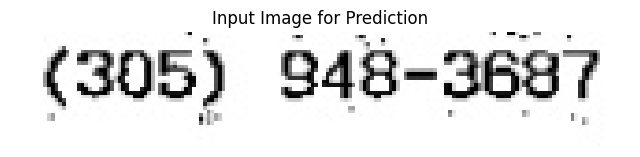

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Decoded: ['1', '0']
Decoded: []


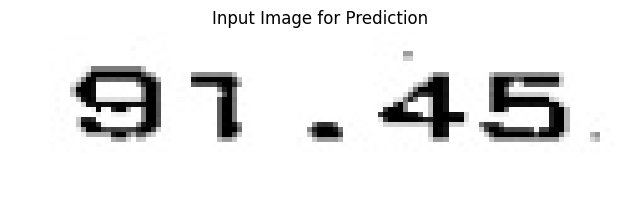

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Decoded: ['1', '.']
Decoded: ['.']


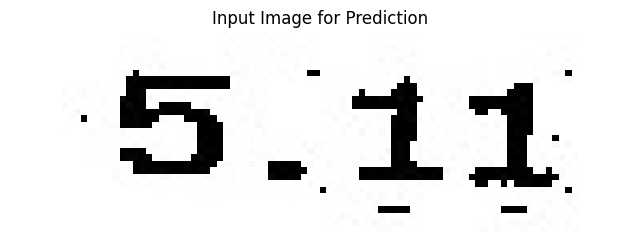

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Decoded: ['1', '.']
Decoded: ['.']


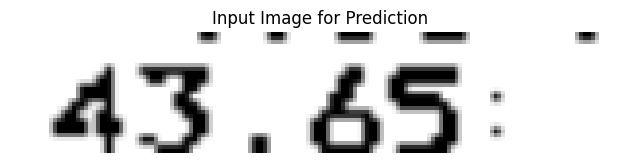

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Decoded: ['1', '.']
Decoded: []


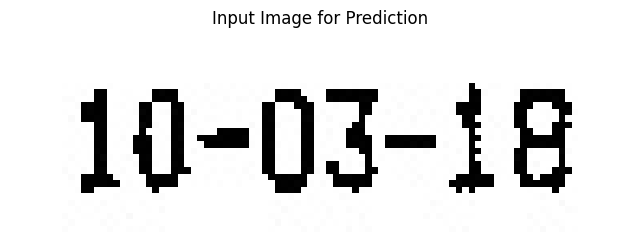

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['1', '0']
Decoded: ['1']


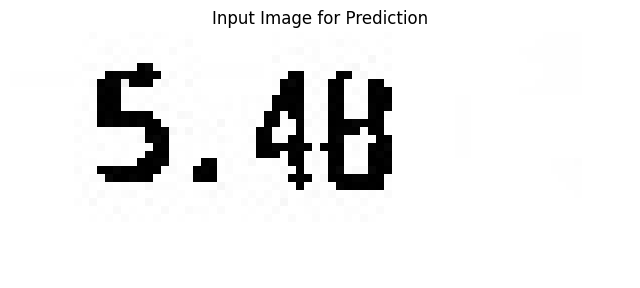

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Decoded: ['1', '0']
Decoded: []


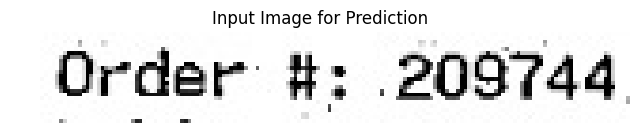

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Decoded: ['1', '.']
Decoded: ['.']


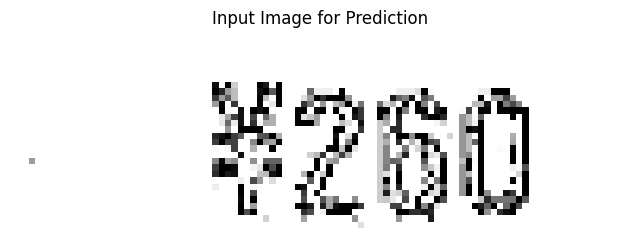

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Decoded: ['1', '.']
Decoded: []


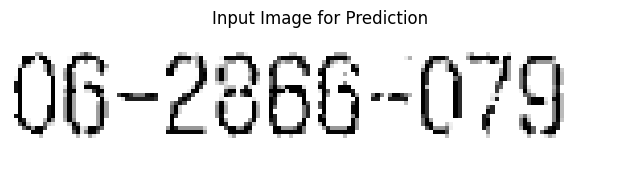

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Decoded: ['1', '0']
Decoded: ['1']


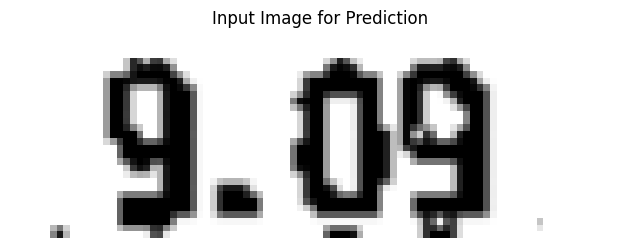

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Decoded: ['1', '.']
Decoded: []


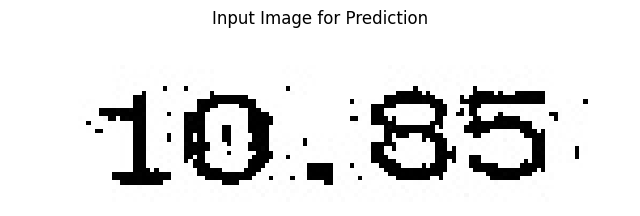

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.']
Decoded: ['.']


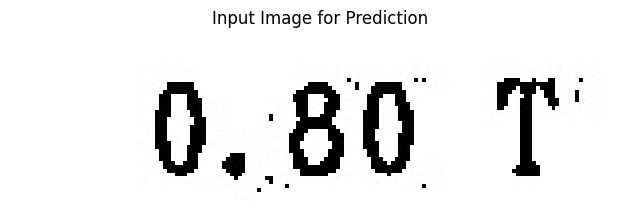

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Decoded: ['1', '.']
Decoded: []


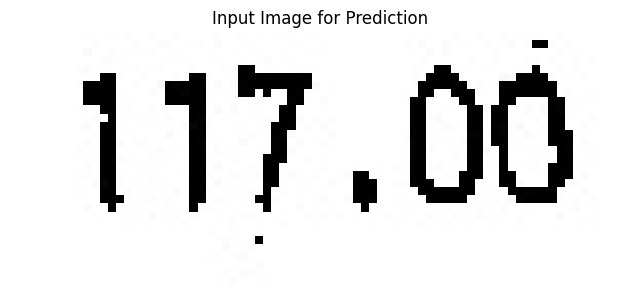

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['1', '0']
Decoded: ['1']


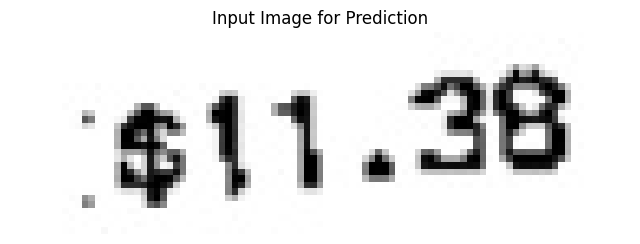

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['1', '.']
Decoded: ['.']


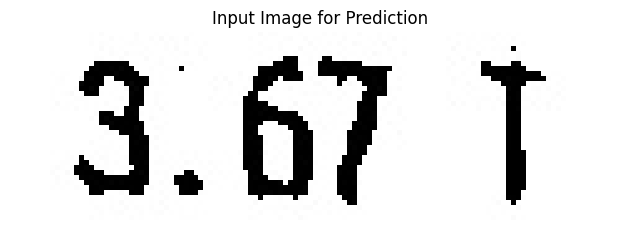

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Decoded: ['1', '.']
Decoded: ['.']


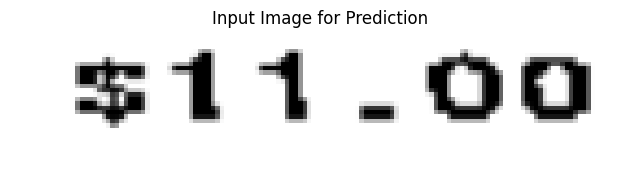

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Decoded: ['1', '.']
Decoded: ['.']


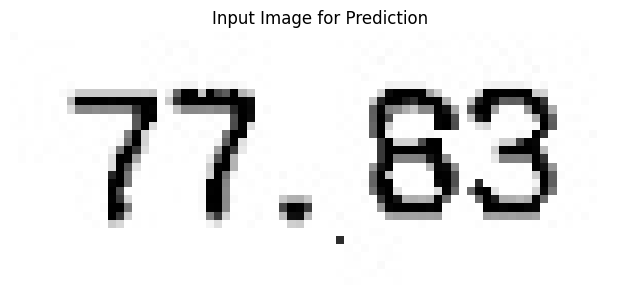

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Decoded: ['1', '.']
Decoded: ['.']


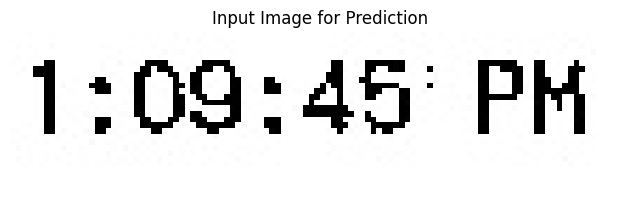

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Decoded: ['1', '0']
Decoded: ['1']


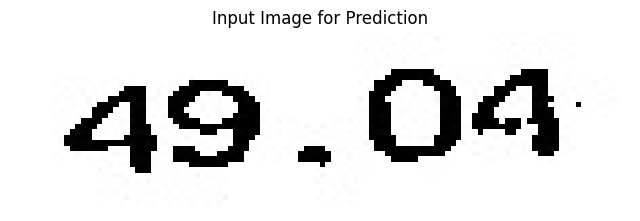

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Decoded: ['1', '.']
Decoded: ['.']


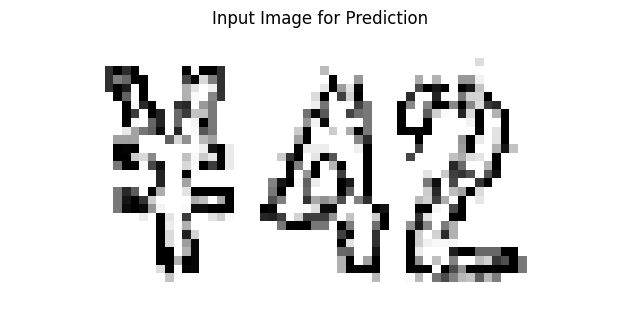

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Decoded: ['1', '0']
Decoded: ['1']


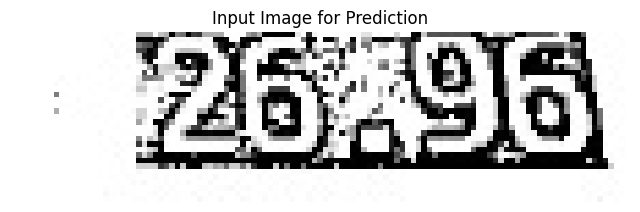

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['0']
Decoded: []


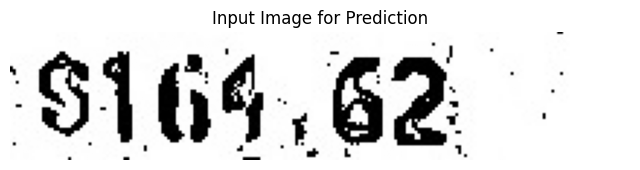

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.']
Decoded: ['$']


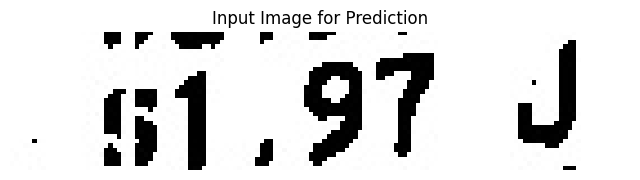

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Decoded: ['1', '.']
Decoded: []


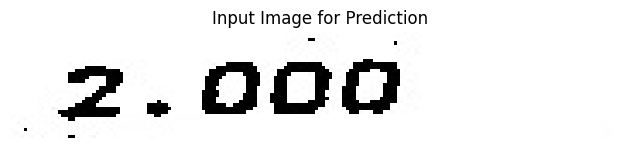

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Decoded: ['1', '.']
Decoded: ['.']


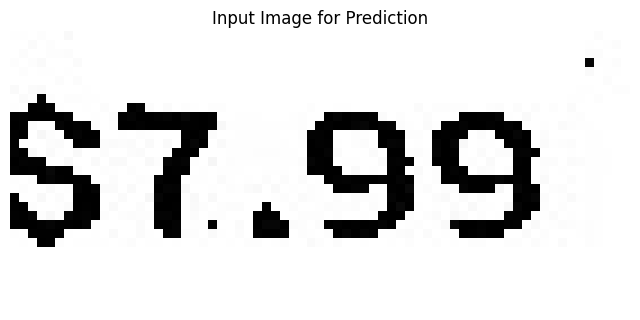

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Decoded: ['1', '.']
Decoded: ['1']


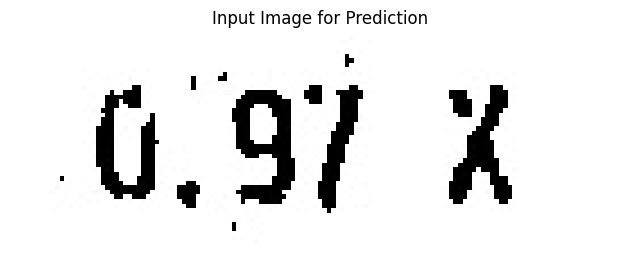

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Decoded: ['1', '0']
Decoded: []


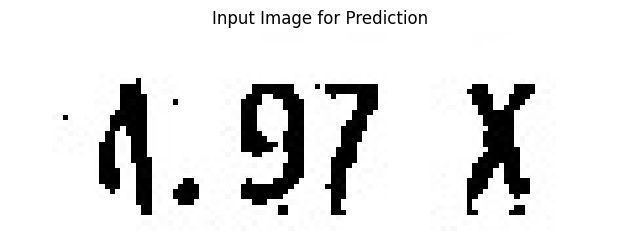

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: ['.']


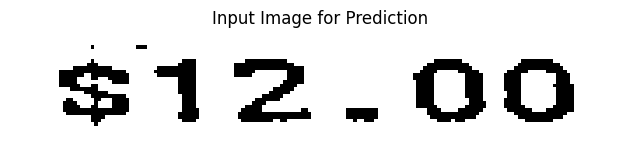

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Decoded: ['1', '.']
Decoded: ['.']


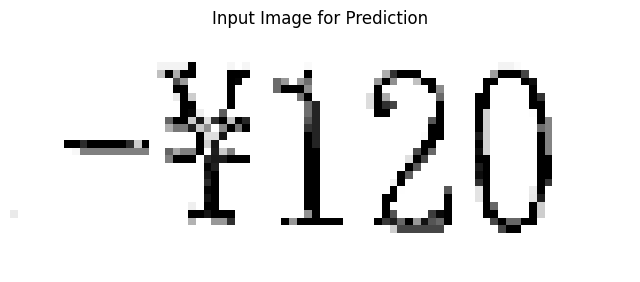

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Decoded: ['1', '0']
Decoded: []


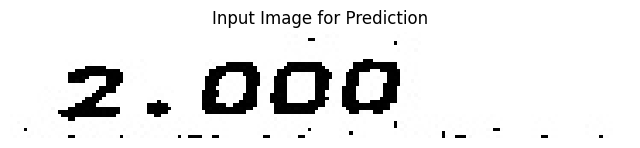

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: ['.']


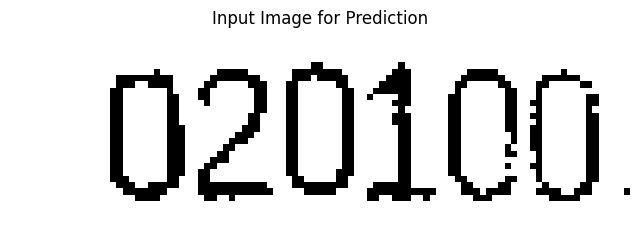

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '0']
Decoded: []


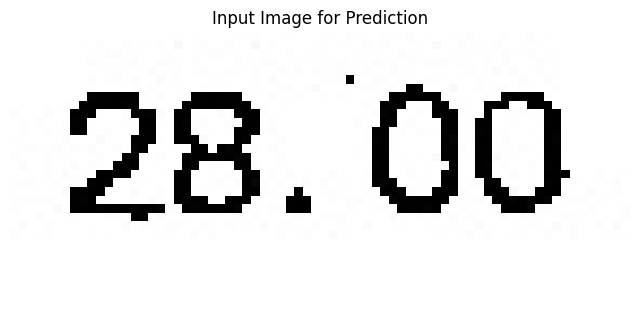

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Decoded: ['1', '0']
Decoded: ['1']


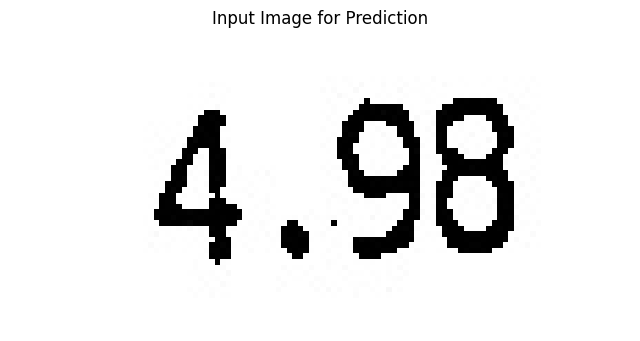

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Decoded: ['1', '.']
Decoded: []


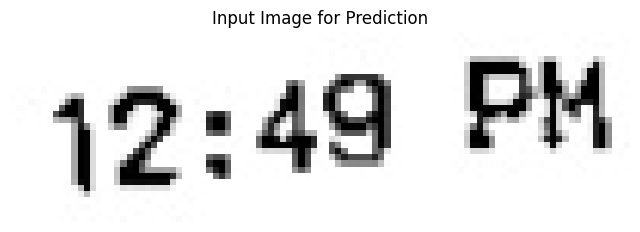

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['1', '.']
Decoded: ['.']


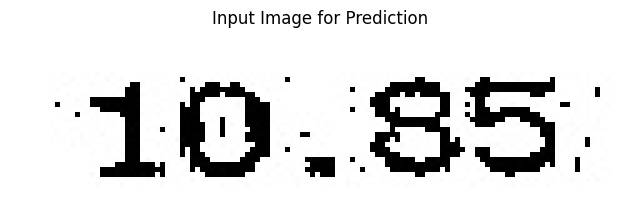

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Decoded: ['1', '.']
Decoded: ['.']


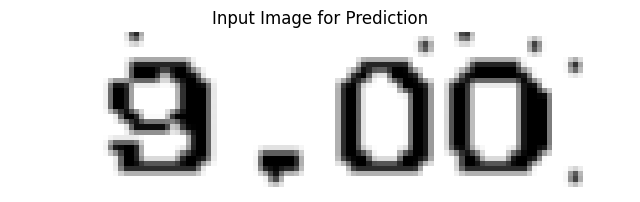

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Decoded: ['1', '.']
Decoded: []


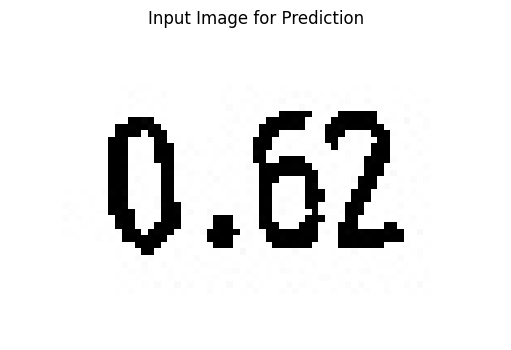

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Decoded: ['1', '.']
Decoded: ['1']


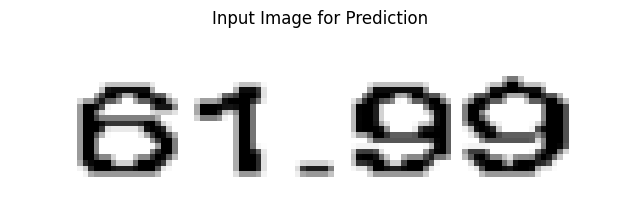

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['1', '.']
Decoded: ['.']


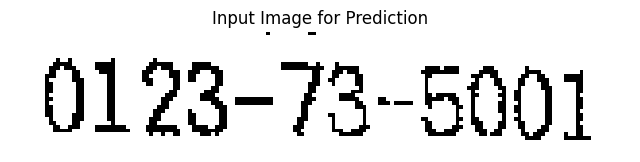

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Decoded: ['1', '0']
Decoded: ['1']


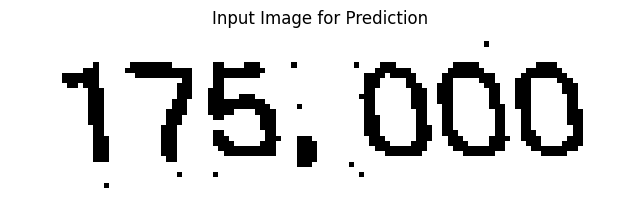

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Decoded: ['1', '0']
Decoded: []


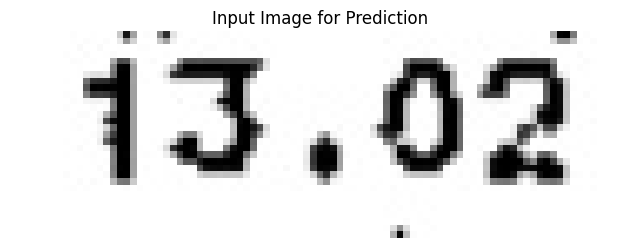

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.']
Decoded: ['.']


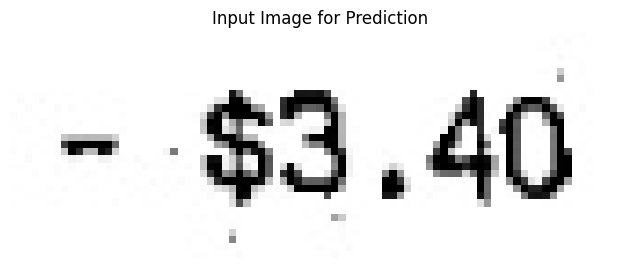

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['1', '.']
Decoded: []


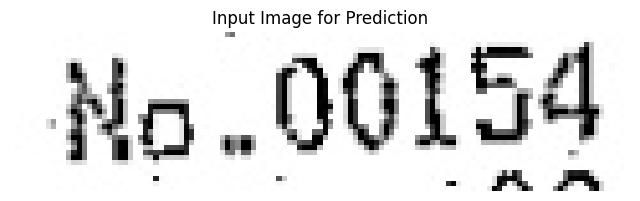

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['1', '.']
Decoded: []


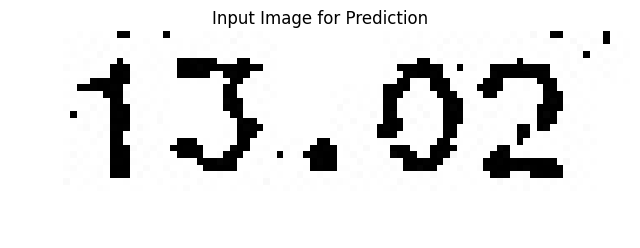

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '0']
Decoded: []


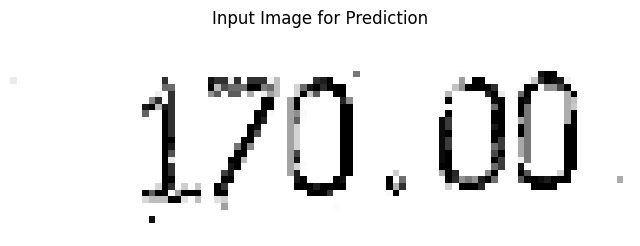

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: []


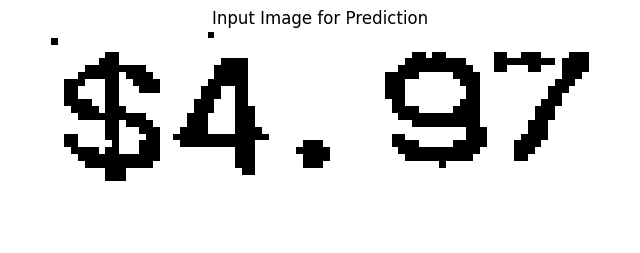

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Decoded: ['1', '0']
Decoded: ['1']


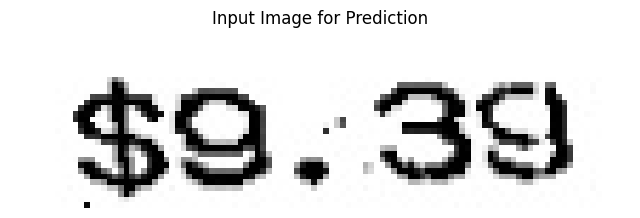

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Decoded: ['1', '.']
Decoded: ['.']


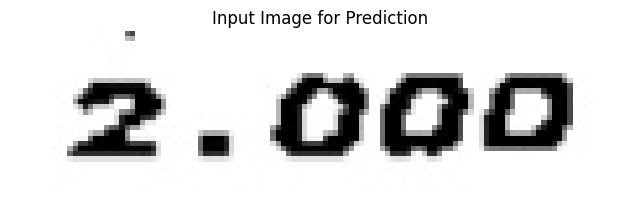

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: []


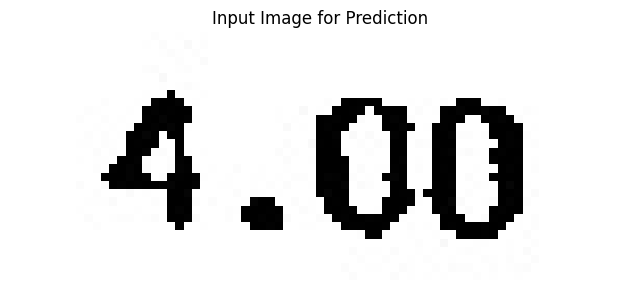

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '.']
Decoded: ['.']


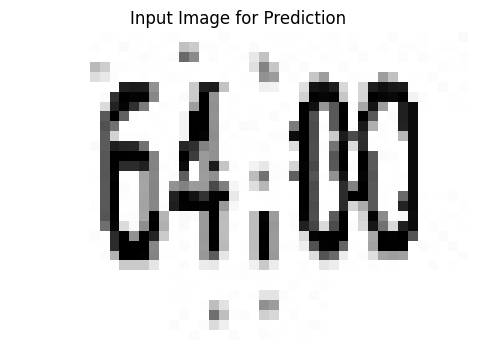

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Decoded: ['1', '0']
Decoded: ['$']


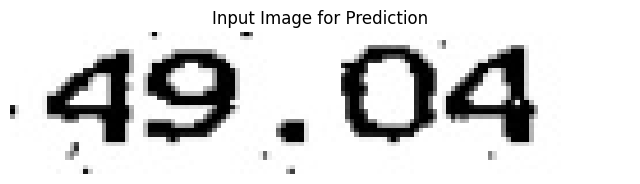

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Decoded: ['1', '.']
Decoded: ['.']


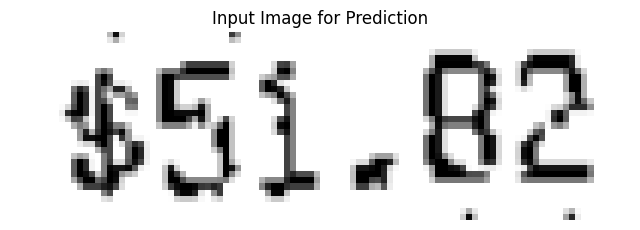

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '.']
Decoded: ['.']


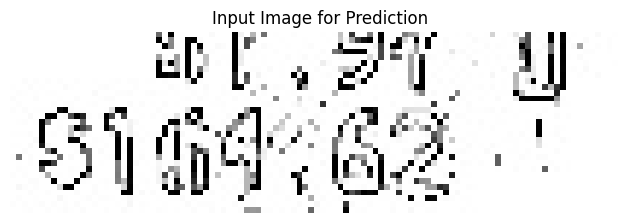

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '0']
Decoded: ['1']


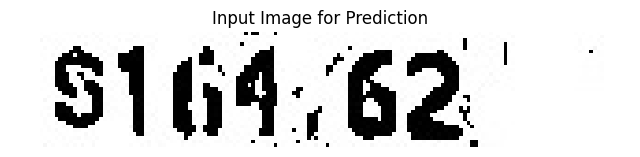

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '0']
Decoded: []


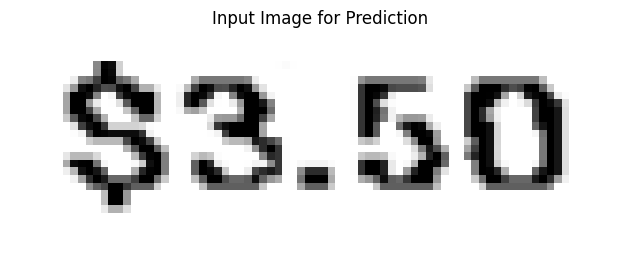

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Decoded: ['1', '.']
Decoded: ['.']


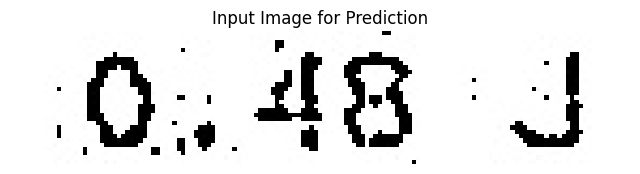

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Decoded: ['1', '.']
Decoded: []


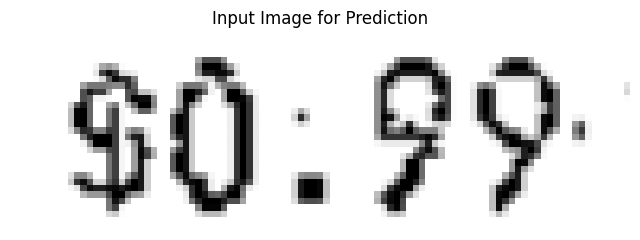

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: ['.']


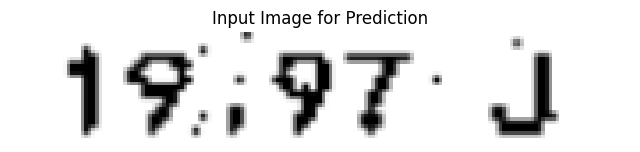

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Decoded: ['1', '.']
Decoded: []


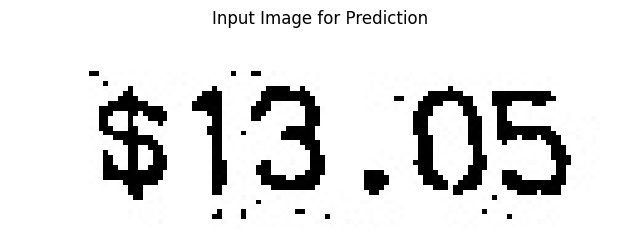

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: []


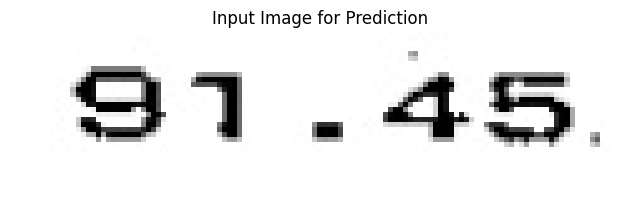

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: ['.']


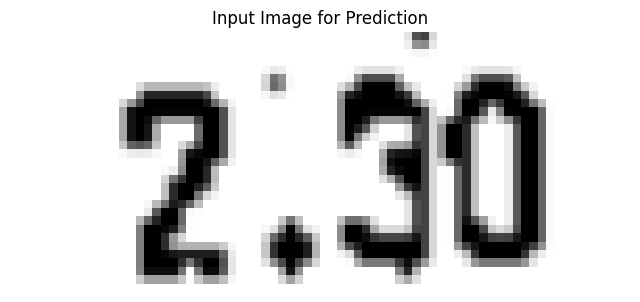

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['1', '.']
Decoded: ['.']


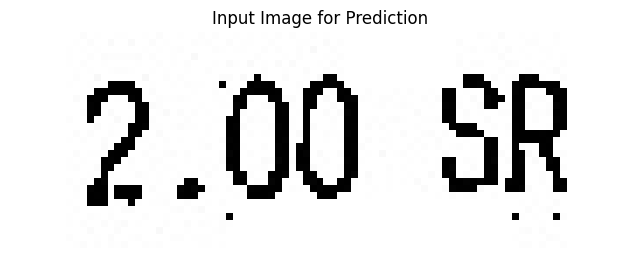

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Decoded: ['1', '0']
Decoded: ['1']


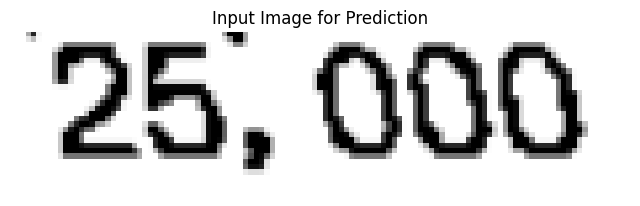

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Decoded: ['1', '.']
Decoded: ['.']


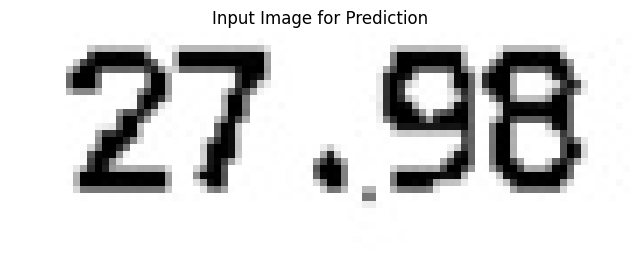

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.']
Decoded: ['.']


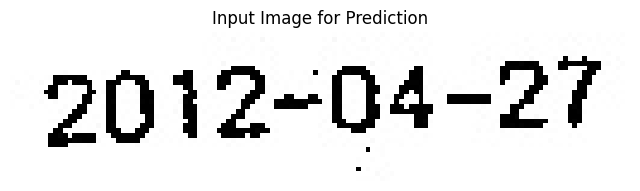

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Decoded: ['1', '0']
Decoded: ['1']


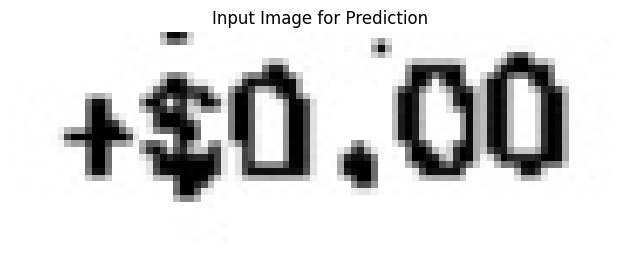

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '.']
Decoded: ['.']


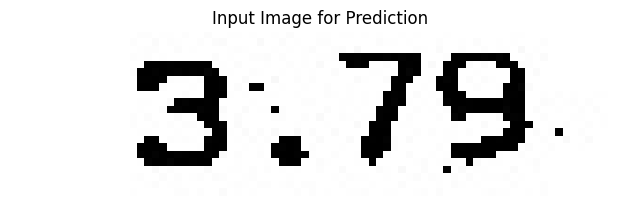

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Decoded: ['1', '.']
Decoded: []


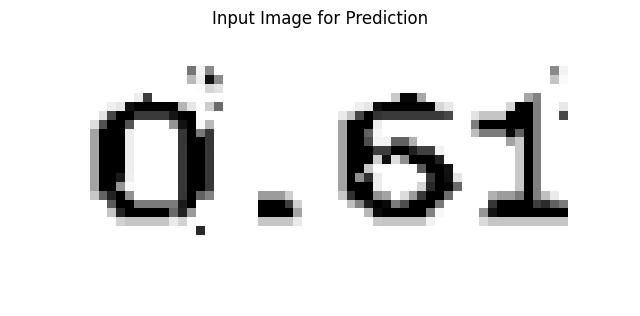

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: ['.']


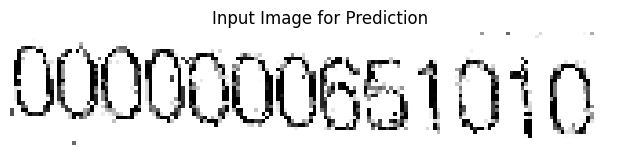

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Decoded: ['1', '0']
Decoded: ['1']


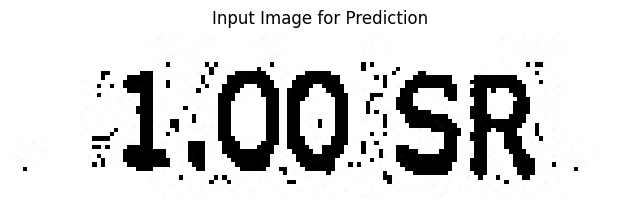

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '.']
Decoded: []


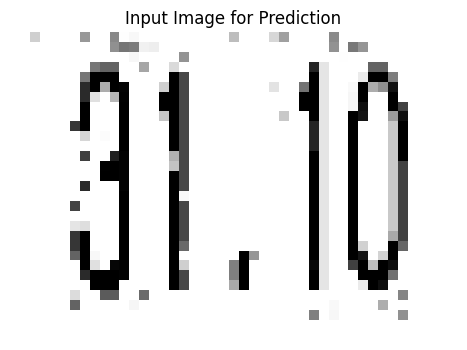

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '0']
Decoded: ['1']


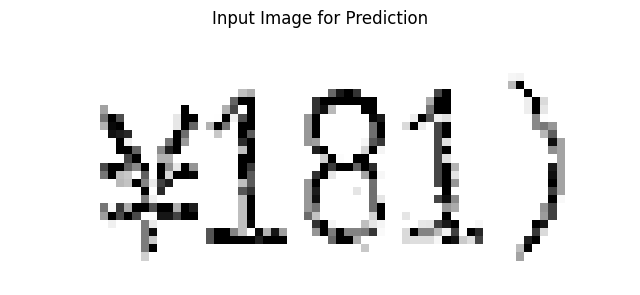

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: ['1']


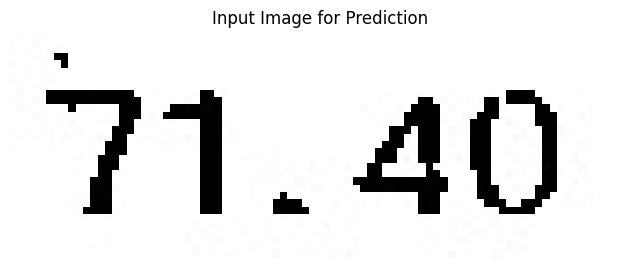

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['1', '0']
Decoded: []


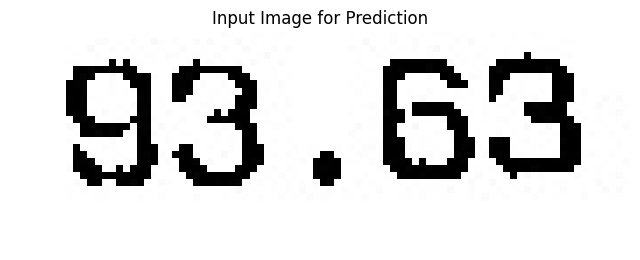

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '0']
Decoded: ['1']


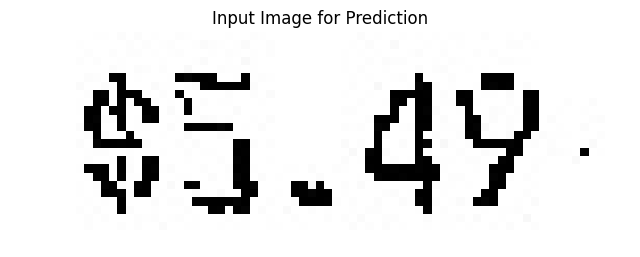

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Decoded: ['1', '.']
Decoded: ['.']


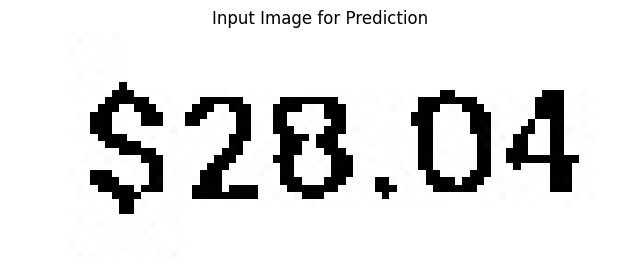

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['1', '0']
Decoded: ['1']


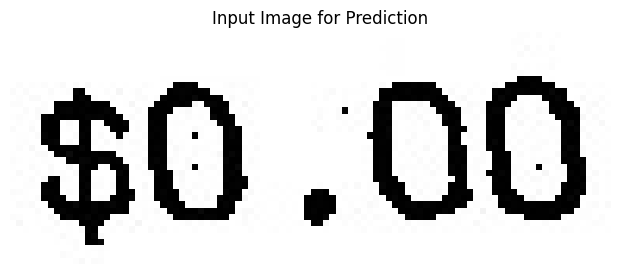

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '.']
Decoded: ['$']


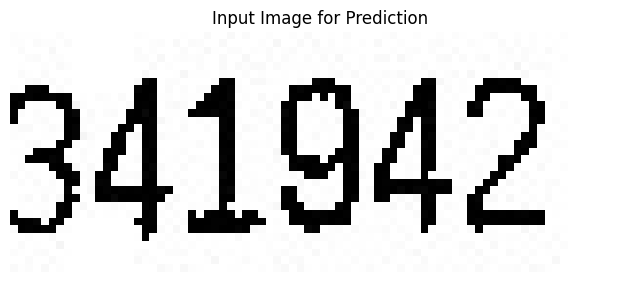

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Decoded: ['1', '0']
Decoded: ['1']


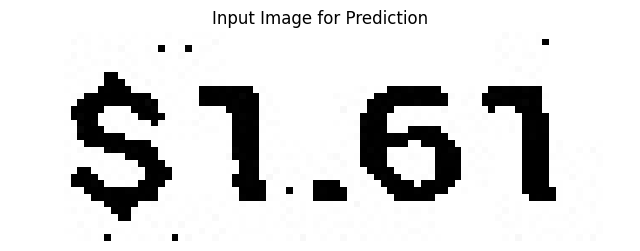

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.']
Decoded: []


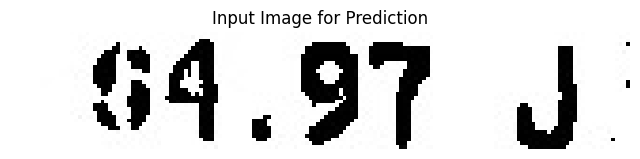

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Decoded: ['1', '.']
Decoded: []


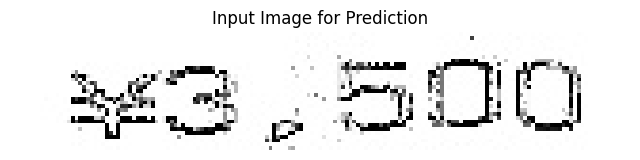

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['1', '.']
Decoded: []


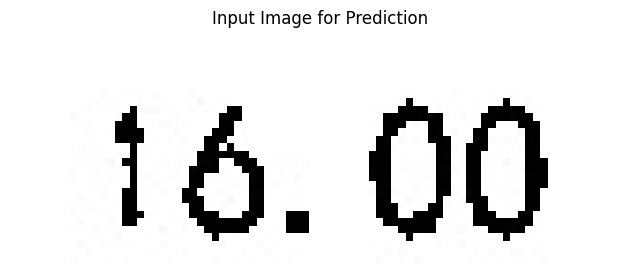

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: []


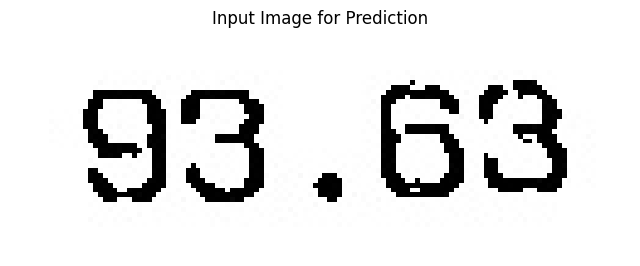

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '0']
Decoded: ['1']


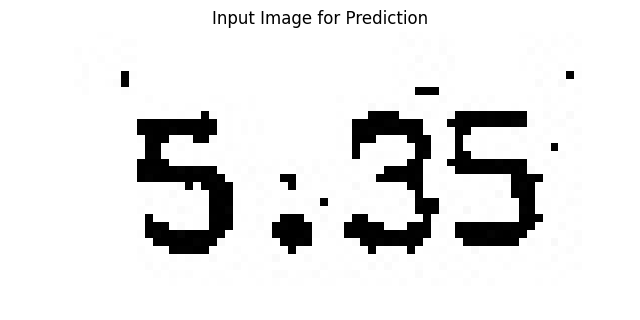

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: ['.']


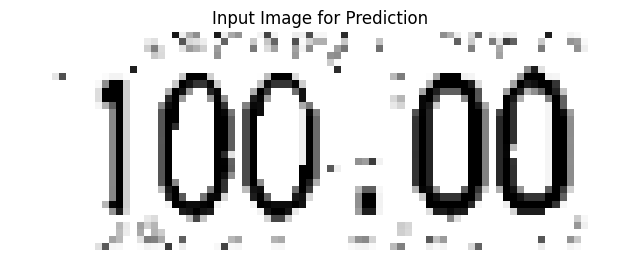

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: []


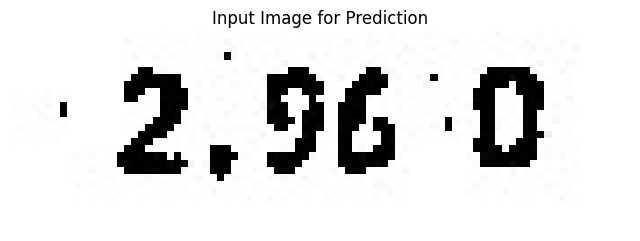

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: ['.']


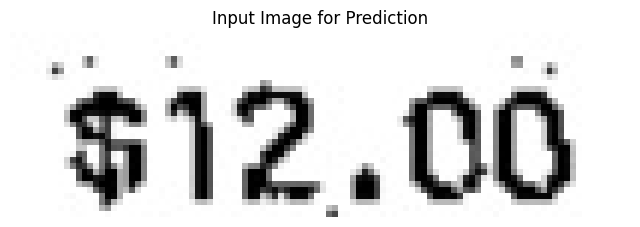

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Decoded: ['1', '.']
Decoded: ['.']


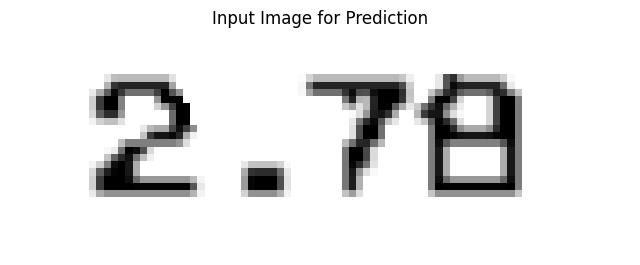

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Decoded: ['1', '.']
Decoded: ['.']


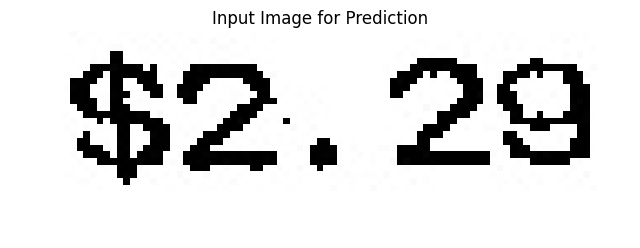

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: ['1']


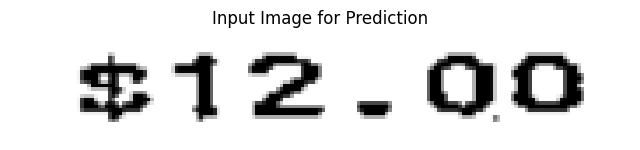

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '.']
Decoded: []


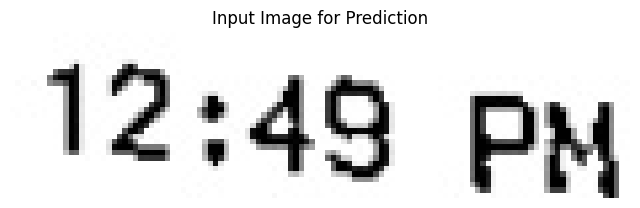

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: ['.']


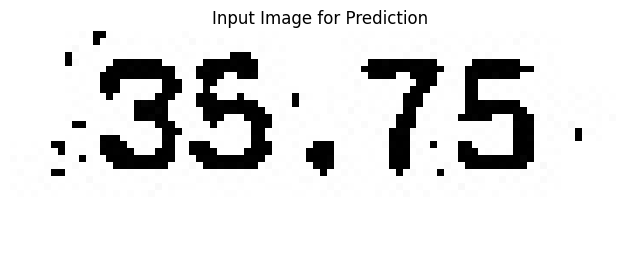

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['1', '0']
Decoded: ['1']


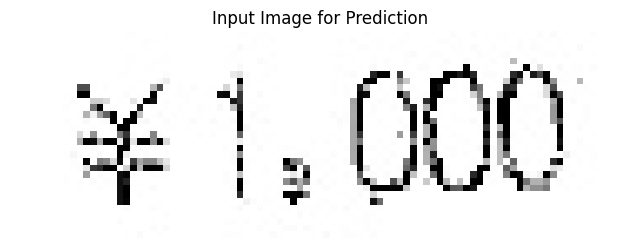

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0']
Decoded: []


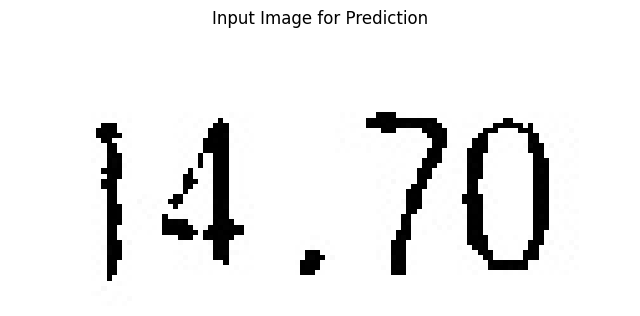

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '.']
Decoded: []


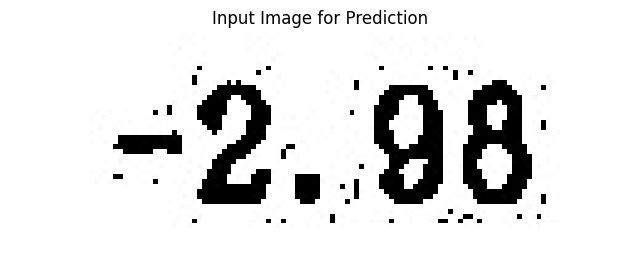

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Decoded: ['1', '.']
Decoded: []


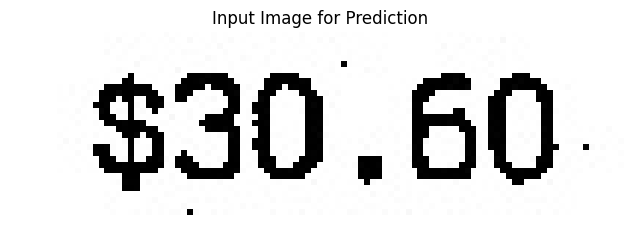

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['1', '0']
Decoded: []


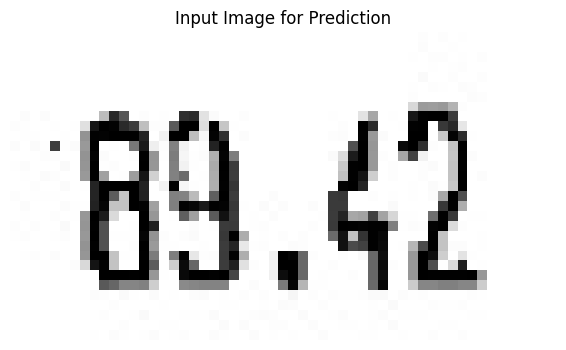

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Decoded: ['1', '0']
Decoded: ['$']


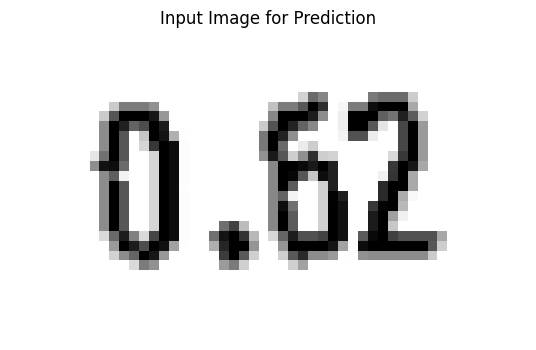

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Decoded: ['1', '0']
Decoded: []


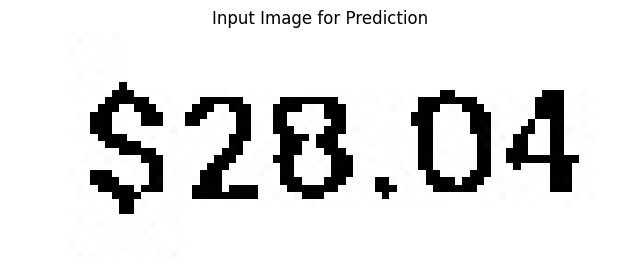

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['1', '0']
Decoded: ['1']


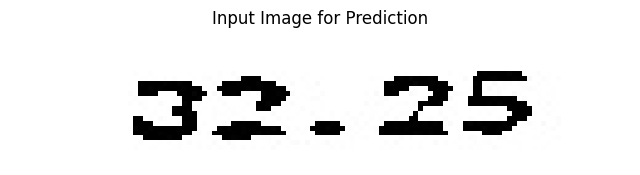

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Decoded: ['1', '.']
Decoded: []


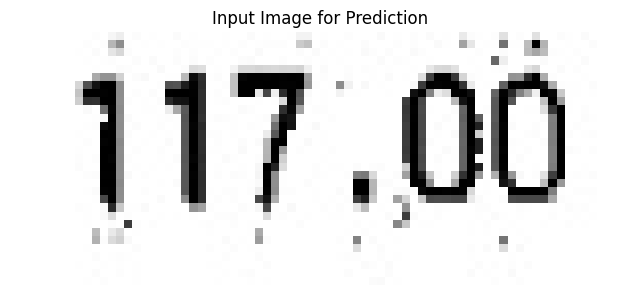

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Decoded: ['1', '0']
Decoded: ['1']


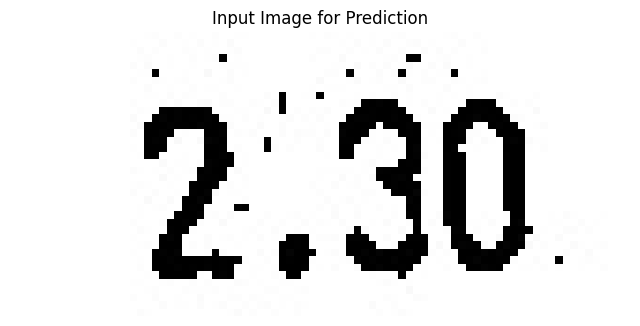

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['1', '.']
Decoded: []


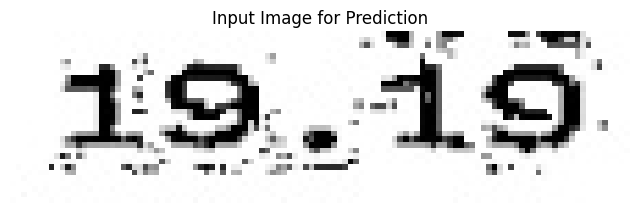

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: ['.']


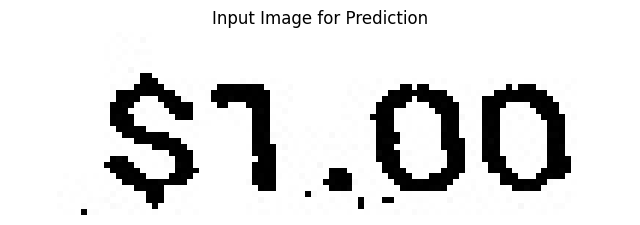

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: []


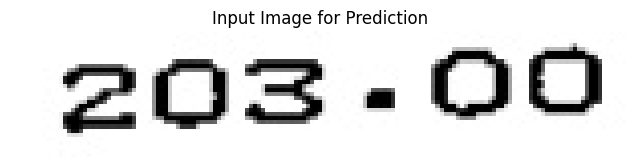

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Decoded: ['1', '.']
Decoded: ['.']


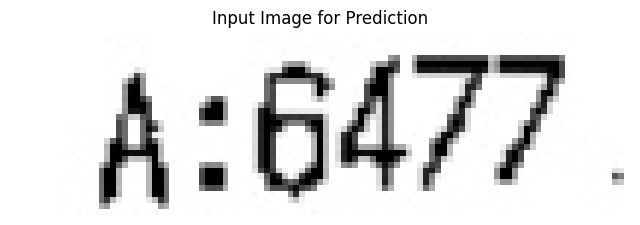

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '.']
Decoded: ['.']


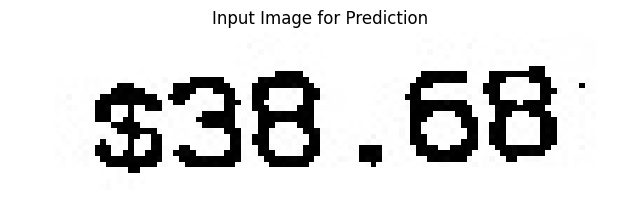

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: []


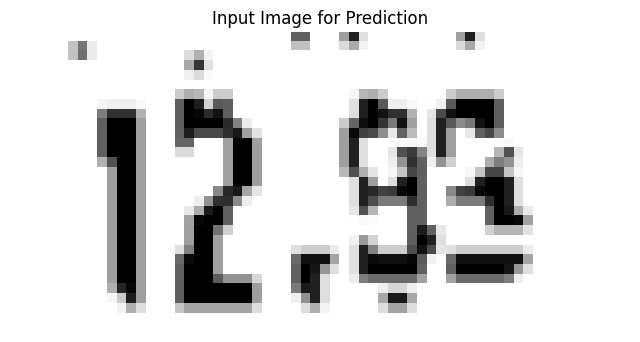

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: ['.']


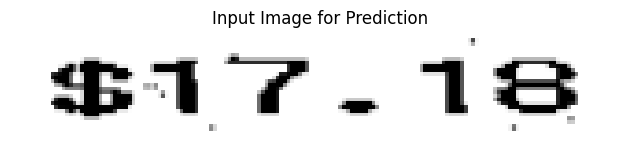

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Decoded: ['1', '.']
Decoded: ['.']


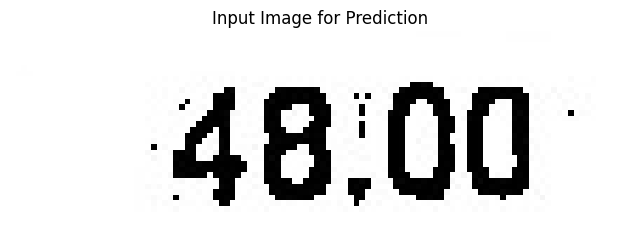

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '.']
Decoded: []


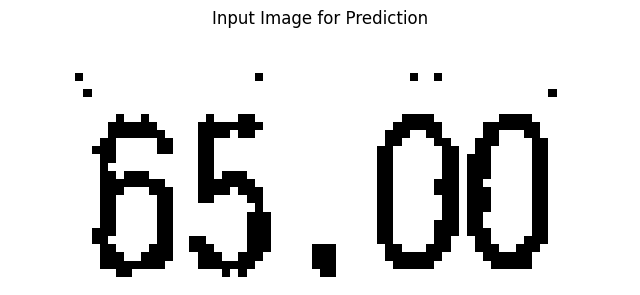

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: ['1']


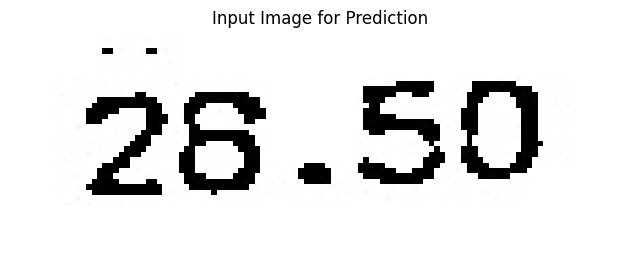

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '0']
Decoded: []


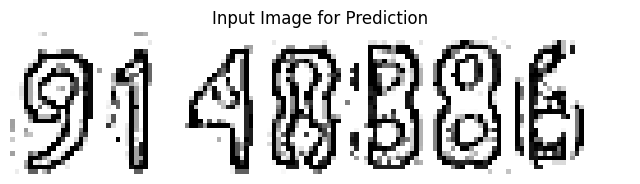

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: ['1']


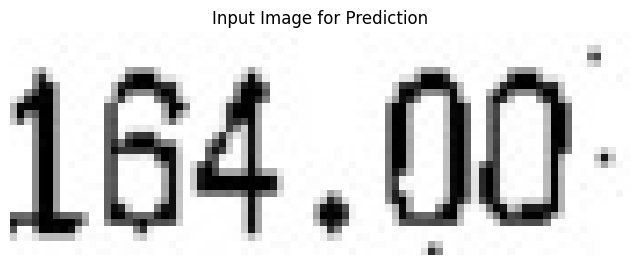

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '.']
Decoded: ['.']


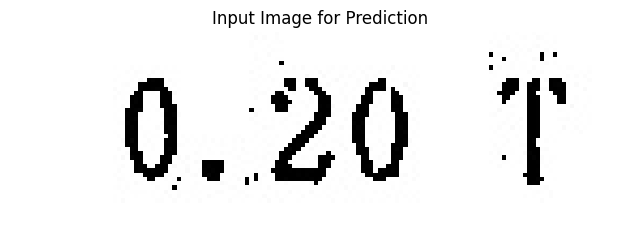

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '.']
Decoded: []


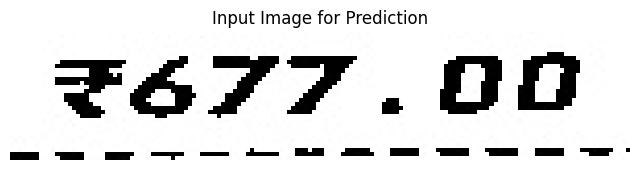

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '.']
Decoded: ['.']


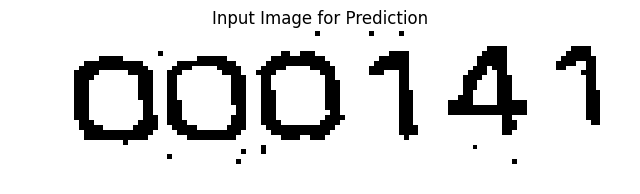

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Decoded: ['1', '0']
Decoded: []


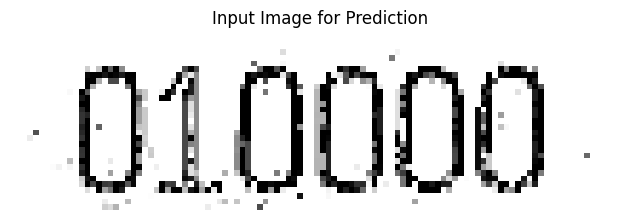

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Decoded: ['1', '0']
Decoded: ['1']


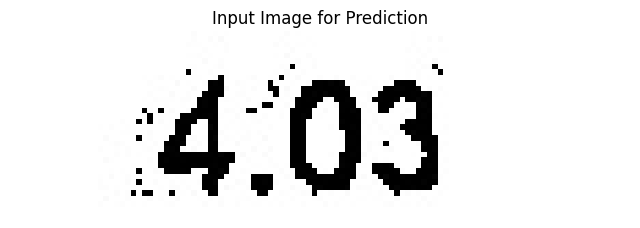

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '.']
Decoded: []


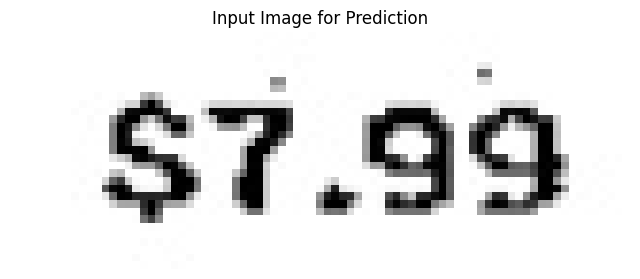

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['1', '.']
Decoded: ['.']


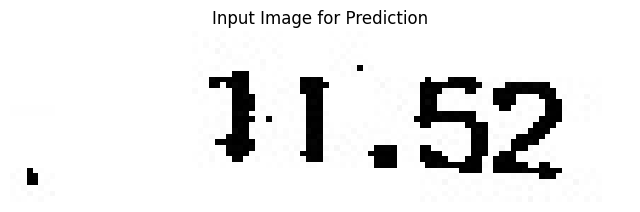

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: []


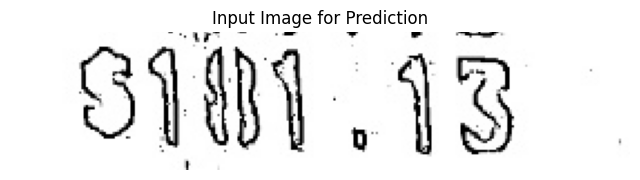

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '.']
Decoded: []


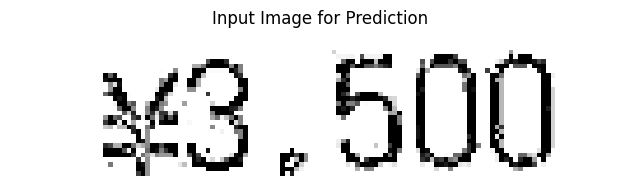

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Decoded: ['1', '.']
Decoded: []


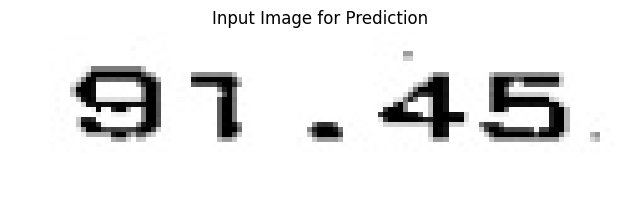

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['1', '.']
Decoded: ['.']


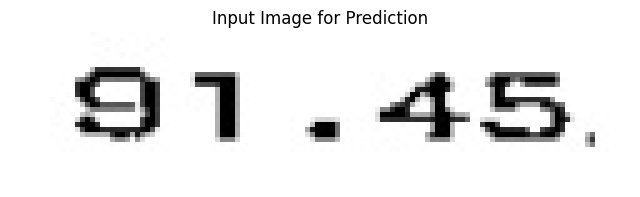

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '.']
Decoded: ['.']


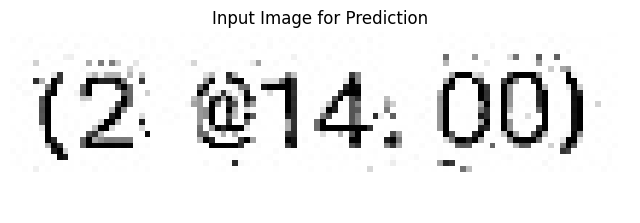

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: ['1']


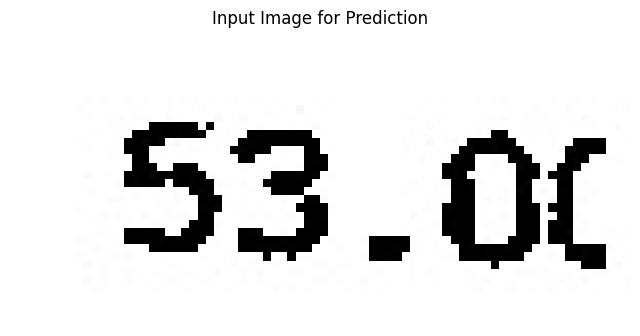

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Decoded: ['1', '.']
Decoded: ['.']


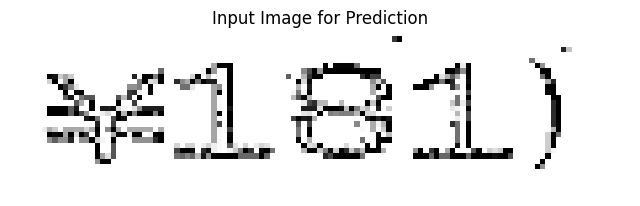

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '0']
Decoded: ['1']


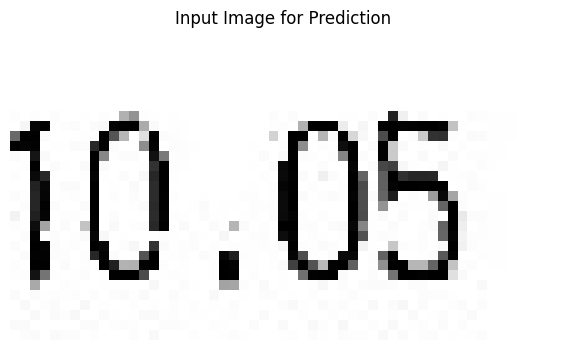

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '0']
Decoded: ['1']


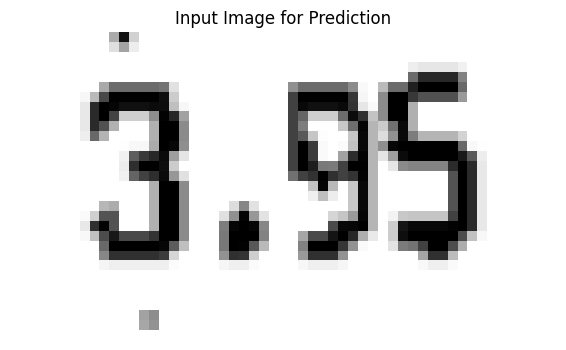

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '.']
Decoded: ['.']


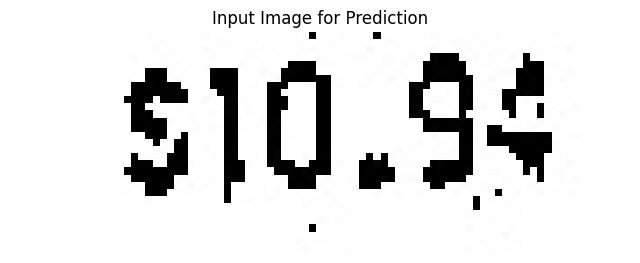

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Decoded: ['1', '0']
Decoded: []


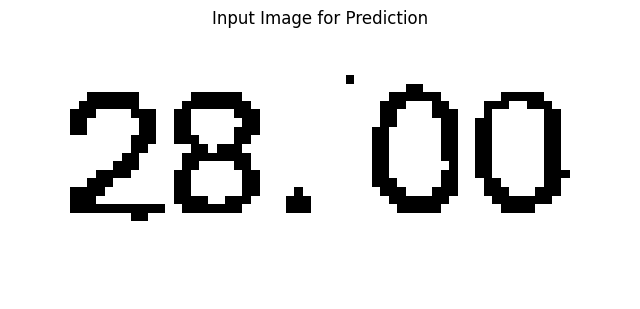

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: ['1']


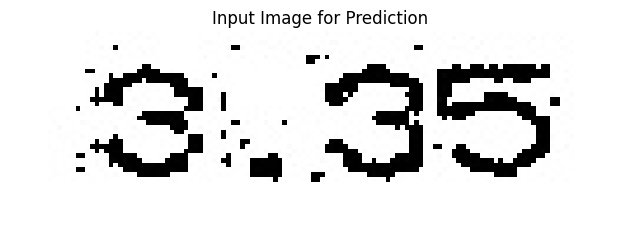

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: []


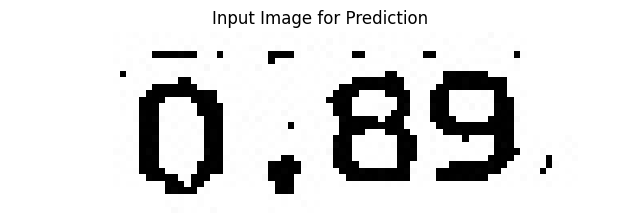

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Decoded: ['1', '.']
Decoded: []


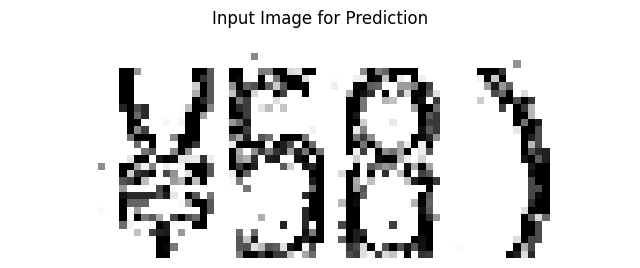

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '0']
Decoded: []


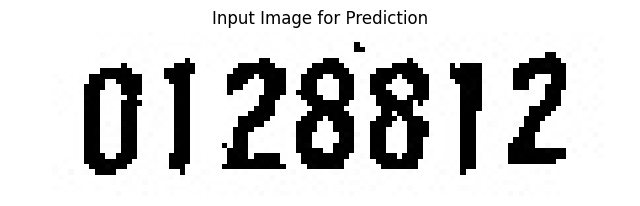

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: []


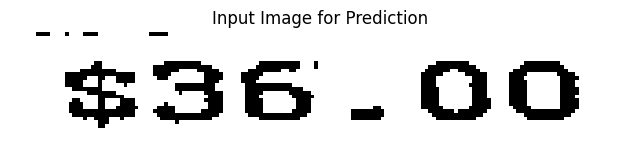

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '.']
Decoded: []


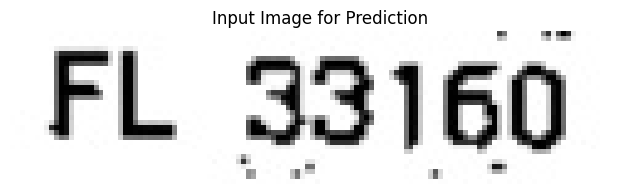

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: ['.']


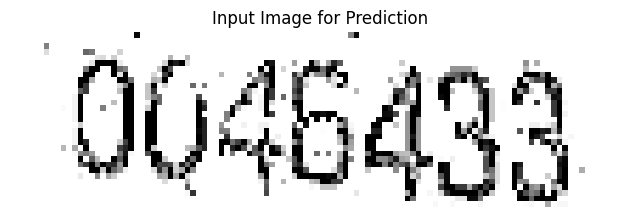

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: ['1']


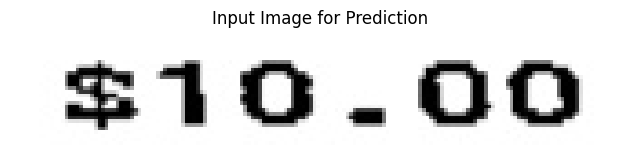

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Decoded: ['1', '.']
Decoded: []


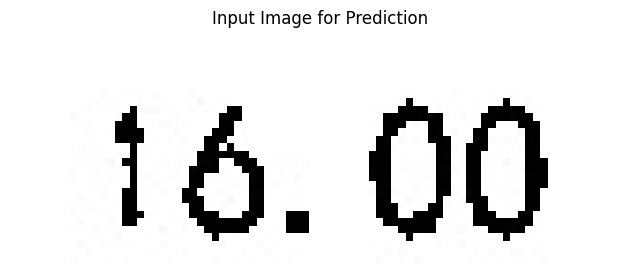

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '0']
Decoded: []


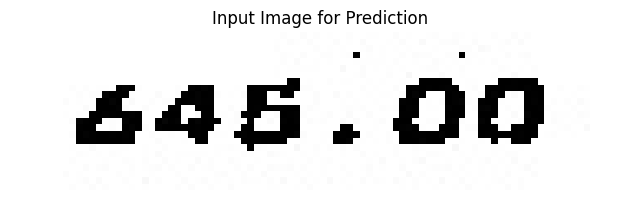

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: []


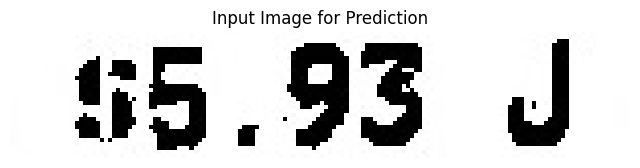

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Decoded: ['1', '.']
Decoded: ['.']


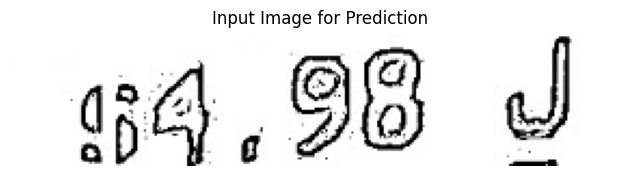

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['1', '.']
Decoded: ['.']


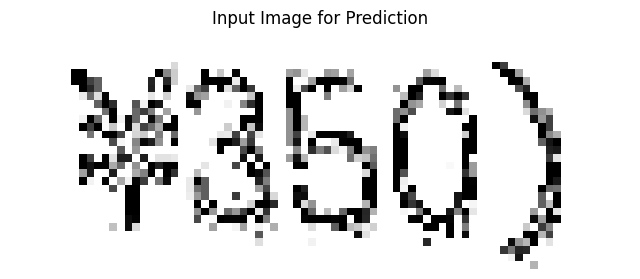

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '0']
Decoded: ['1']


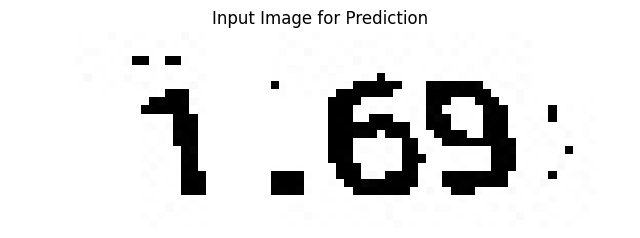

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '.']
Decoded: []


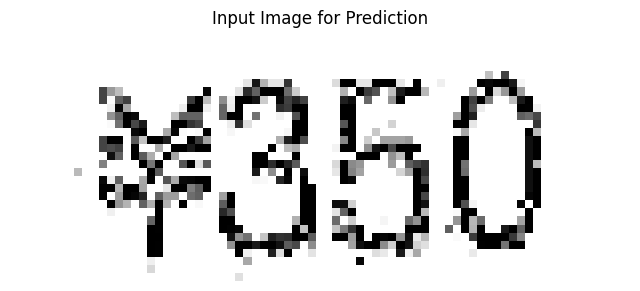

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: ['1']


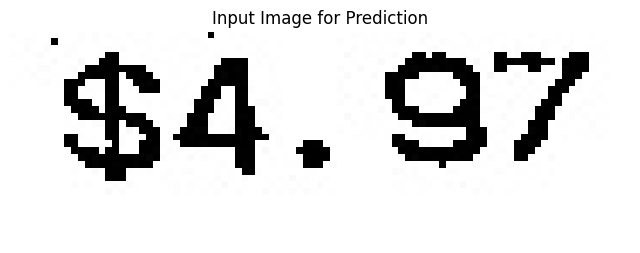

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: ['1']


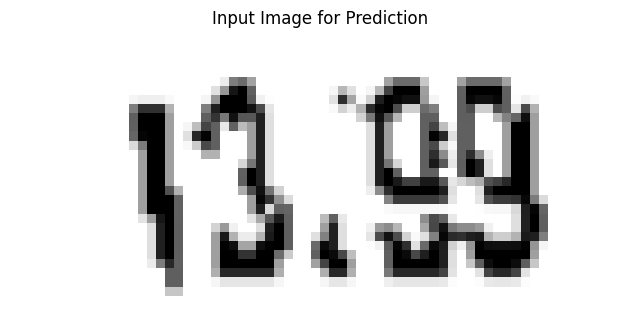

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: ['.']


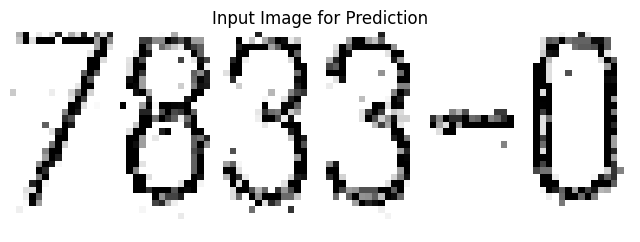

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Decoded: ['1', '0']
Decoded: ['1']


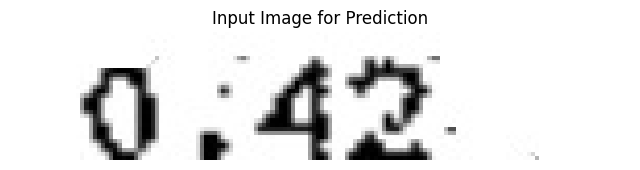

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: []


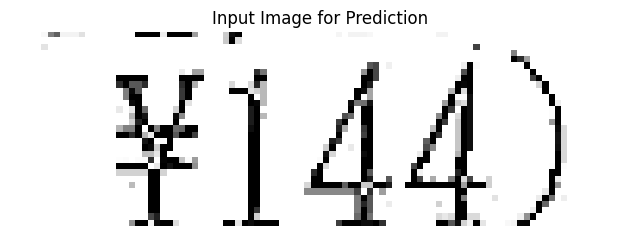

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: []


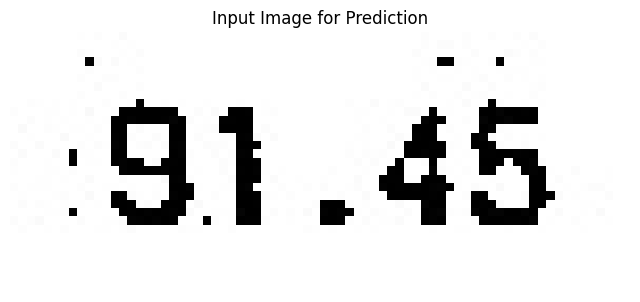

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '0']
Decoded: ['1']


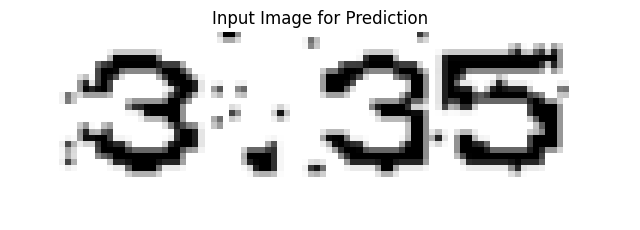

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Decoded: ['1', '.']
Decoded: ['.']


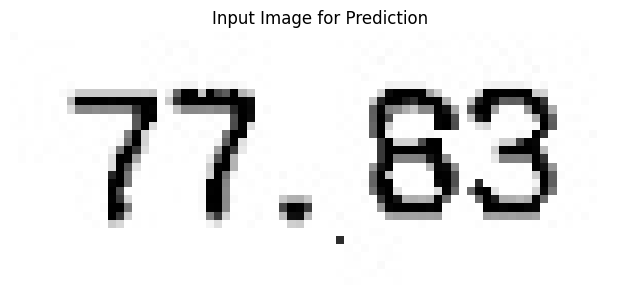

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Decoded: ['1', '.']
Decoded: ['.']


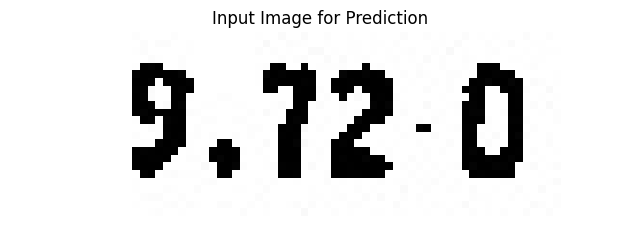

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Decoded: ['1', '.']
Decoded: []


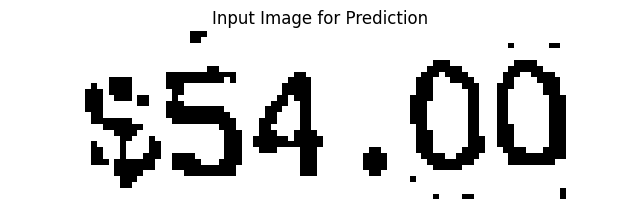

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Decoded: ['1', '0']
Decoded: []


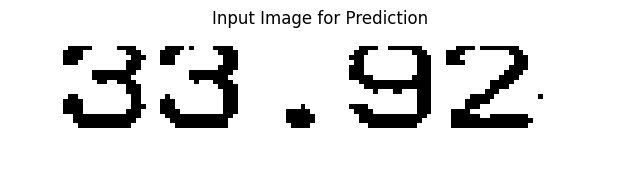

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Decoded: ['1', '.']
Decoded: ['.']


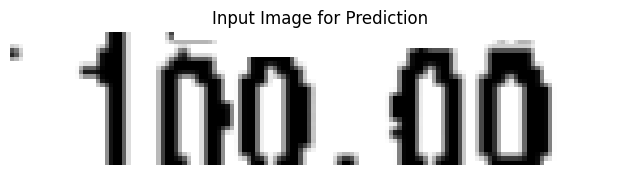

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Decoded: ['1', '.']
Decoded: []


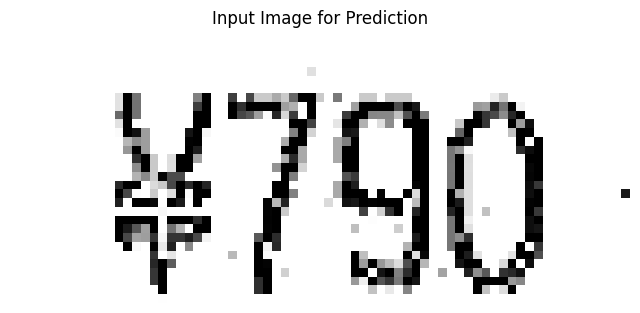

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Decoded: ['1', '0']
Decoded: ['1']


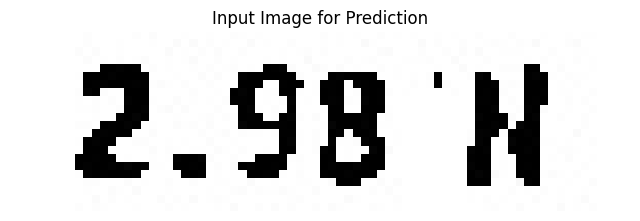

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Decoded: ['1', '.']
Decoded: []


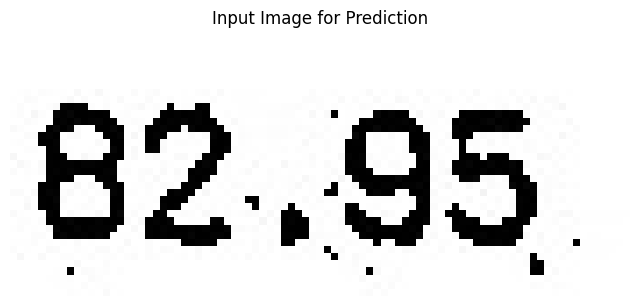

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Decoded: ['1', '.']
Decoded: ['$']


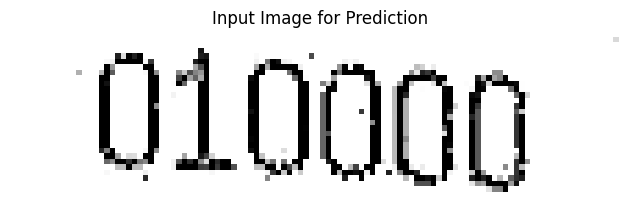

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '0']
Decoded: []


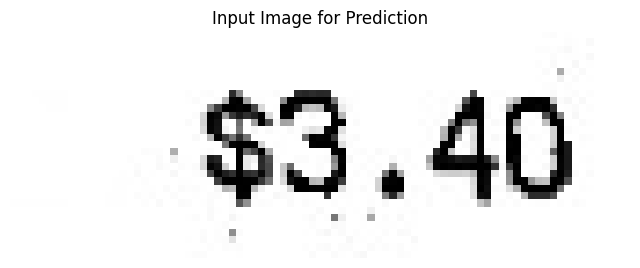

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['1', '.']
Decoded: []


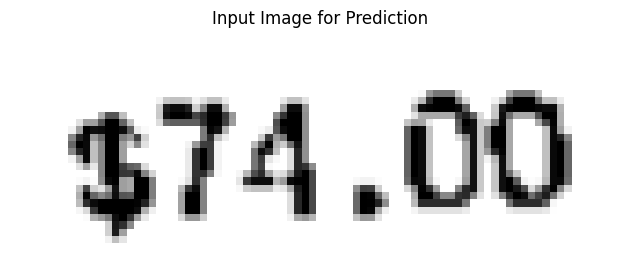

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Decoded: ['1', '.']
Decoded: ['.']


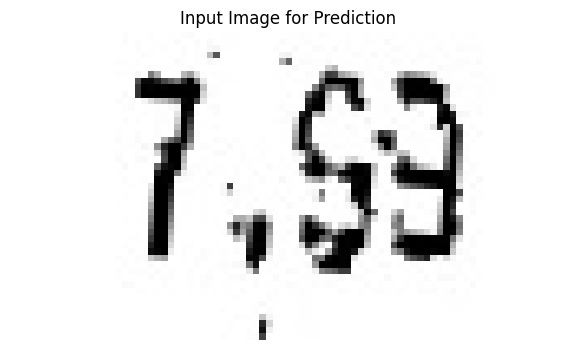

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Decoded: ['1', '.']
Decoded: []


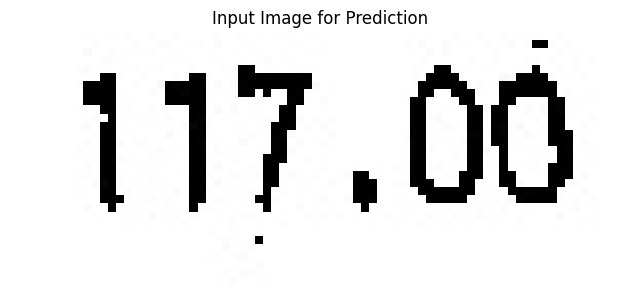

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Decoded: ['1', '0']
Decoded: ['1']


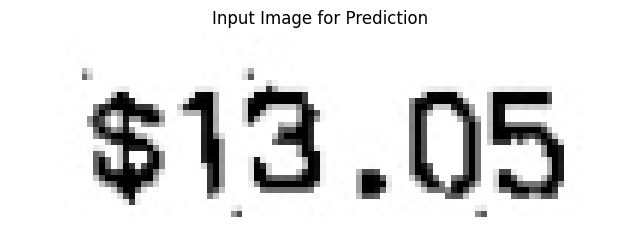

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '.']
Decoded: ['.']


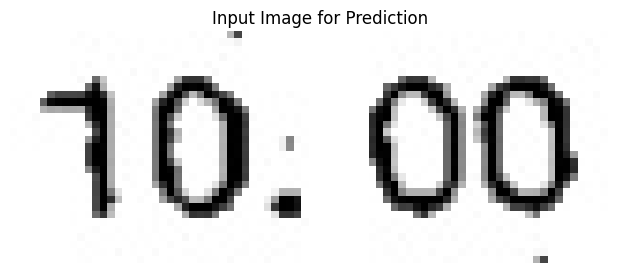

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Decoded: ['1', '.']
Decoded: ['.']


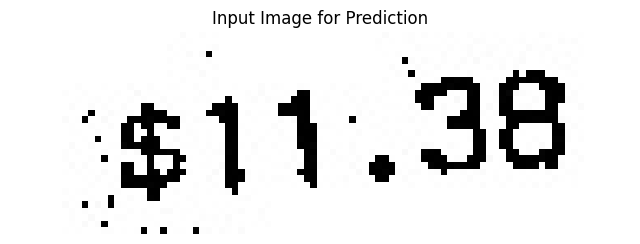

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '0']
Decoded: []


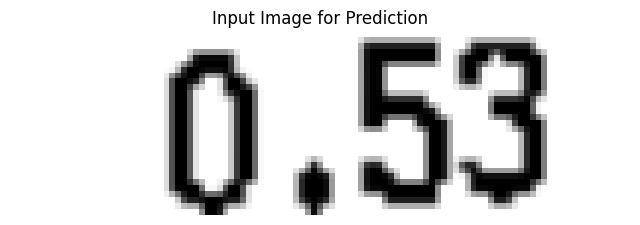

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '.']
Decoded: []


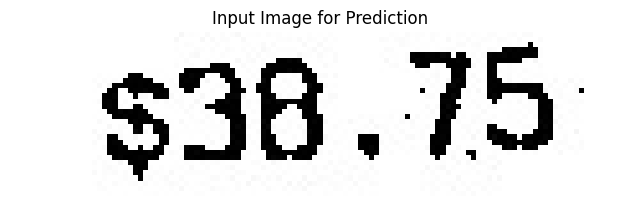

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Decoded: ['1', '.']
Decoded: []


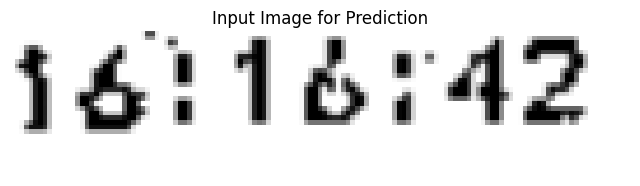

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Decoded: ['1', '.']
Decoded: ['.']


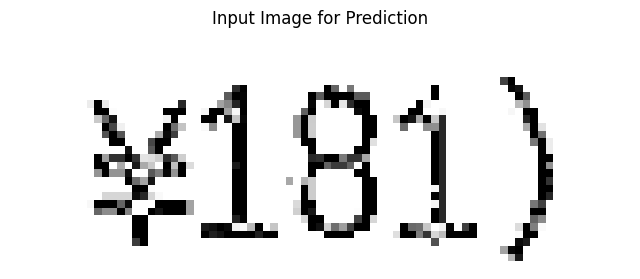

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Decoded: ['1', '0']
Decoded: ['1']


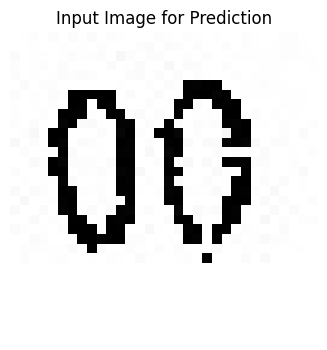

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Decoded: ['1', '.']
Decoded: ['$']


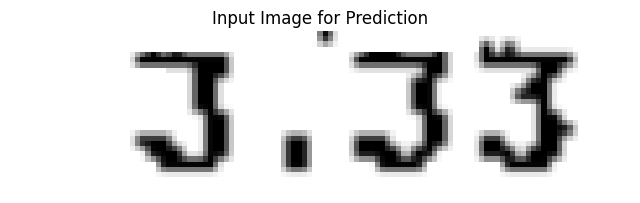

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Decoded: ['1', '.']
Decoded: []


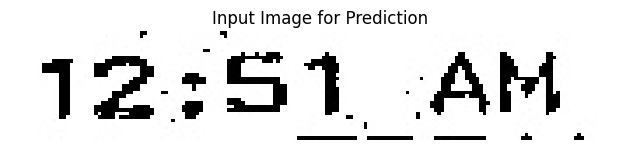

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Decoded: ['1', '.']
Decoded: []


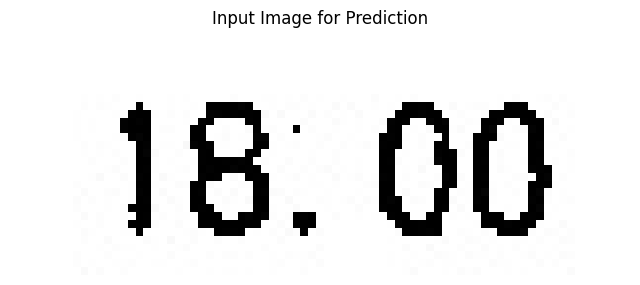

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Decoded: ['1', '0']
Decoded: []


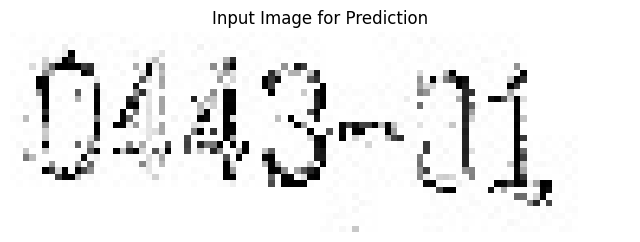

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Decoded: ['1', '0']
Decoded: ['1']


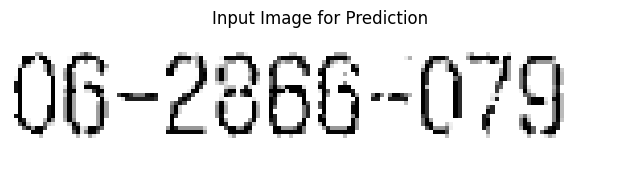

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Decoded: ['1', '0']
Decoded: ['1']


In [8]:
import matplotlib.pyplot as plt
import cv2
import random

# Shuffle the paths
random.shuffle(image_paths)

# Take the first 30 after shuffling
for path in image_paths[:200]:
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  # Read the first image
  # Display
  plt.figure(figsize=(8,4))
  plt.imshow(img, cmap='gray')
  plt.title("Input Image for Prediction")
  plt.axis('off')
  plt.show()


  # -------------------
  # Inference example
  # -------------------
  # Preprocess the image for inference
  # img = cv2.imread(image_paths[10], cv2.IMREAD_GRAYSCALE)

  # Apply the same preprocessing as in the data generator
  # Preprocess
  img_height = 31

  # Add margin by creating a slightly larger canvas
  # h, w = img.shape[:2]
  # canvas = np.ones((h + 2*margin, w + 2*margin), dtype=np.uint8) * 255
  # canvas[margin:margin+h, margin:margin+w] = img
  # img = canvas

  h, w = img.shape[:2]
  scale = img_height / h
  new_w = int(w * scale)
  resized = cv2.resize(img, (new_w, img_height))

  img = resized.astype(np.float32) / 255.0
  img = np.expand_dims(img, axis=(0, -1)) # Add batch and channel dimensions


  preds = base_model.predict(img)
  decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=False, beam_width=8)

  decoded_indices = decoded[0].numpy()[0]
  decoded_text = [idx_to_char[i] for i in decoded_indices if i > 0]  # skip 0 and negatives
  print("Decoded:", decoded_text)

  decoded, _ = tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)
  decoded_indices = decoded[0].numpy()[0]
  decoded_text = [idx_to_char[i] for i in decoded_indices if i > 0]  # skip 0 and negatives
  print("Decoded:", decoded_text)

In [9]:
base_model.save("crnn_model.keras")

In [10]:
base_model.save("crnn_model.h5")
